In [28]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [29]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import random
from tensorflow.keras import regularizers

In [30]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [31]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [32]:
tf.keras.backend.clear_session()

In [33]:
import shap
shap.initjs()

In [34]:
subject = 'Paraná - Consumo de Cimento (t)'
start_index = 0
split_index = 179
window_size = 0
train_split = split_index + 1 - 12

In [35]:
data = pd.read_csv('2003_mo_model_input_PR.csv')
pd.set_option('display.max_columns', None)
data

Unnamed: 0  Paraná- custo m2 (R$)  Paraná - IDH Renda  \
0       2003-1           11767.370000            0.800130   
1       2003-2           11852.421538            0.799796   
2       2003-3           11934.318946            0.799462   
3       2003-4           12015.342874            0.799128   
4       2003-5           12093.451150            0.798794   
..         ...                    ...                 ...   
244     2023-5           39310.840386                 NaN   
245     2023-6           39274.836083                 NaN   
246     2023-7           39220.898111                 NaN   
247     2023-8           39146.237796                 NaN   
248     2023-9           39010.575490                 NaN   

     Paraná - Depósito Poupança (R$)  Paraná - Desemprego  \
0                       1.312029e+07             8.284196   
1                       1.313619e+07             8.277973   
2                       1.315208e+07             8.271750   
3                       1.316797e+07             8.265527   
4                       1.318386e+07             8.259304   
..                               ...                  ...   
244                              NaN                  NaN   
245                              NaN                  NaN   
246                              NaN                  NaN   
247                              NaN                  NaN   
248                              NaN                  NaN   

     Paraná - Preço do Cimento  Precipitação (mm/day)  \
0                     0.300568                    NaN   
1                     0.301710                    NaN   
2                     0.302645                    NaN   
3                     0.303413                    NaN   
4                     0.304034                    NaN   
..                         ...                    ...   
244                        NaN                    NaN   
245                        NaN                    NaN   
246                        NaN                    NaN   
247                        NaN                    NaN   
248                        NaN                    NaN   

     Pressão Atmosférica (mB)  Radiação Global - Dia (Kj/m²)  \
0                         NaN                            NaN   
1                         NaN                            NaN   
2                         NaN                            NaN   
3                         NaN                            NaN   
4                         NaN                            NaN   
..                        ...                            ...   
244                       NaN                            NaN   
245                       NaN                            NaN   
246                       NaN                            NaN   
247                       NaN                            NaN   
248                       NaN                            NaN   

     Temperatura do Ar - Bulbo Seco (°C)  \
0                                    NaN   
1                                    NaN   
2                                    NaN   
3                                    NaN   
4                                    NaN   
..                                   ...   
244                                  NaN   
245                                  NaN   
246                                  NaN   
247                                  NaN   
248                                  NaN   

     Temperatura de Ponto de Orvalho (°C)  Humidade Relativa do Ar (%)  \
0                                     NaN                          NaN   
1                                     NaN                          NaN   
2                                     NaN                          NaN   
3                                     NaN                          NaN   
4                                     NaN                          NaN   
..                                    ...                          ...   
244                                  

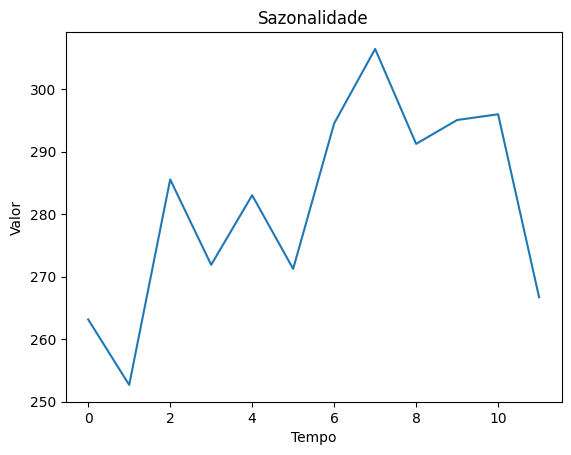

Sazonalidade
Sazonalidade              
0               263.135121
1               252.658185
2               285.543932
3               271.875411
4               283.017533
5               271.230299
6               294.502922
7               306.431532
8               291.234296
9               295.058820
10              295.973515
11              266.682500

In [36]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['Sazonalidade'] = df.index % 12
    monthly_means = df.groupby('Sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'Sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [37]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['Sazonalidade'].tolist()
    df_og['Sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

Unnamed: 0  Paraná- custo m2 (R$)  Paraná - IDH Renda  \
0       2003-1           11767.370000            0.800130   
1       2003-2           11852.421538            0.799796   
2       2003-3           11934.318946            0.799462   
3       2003-4           12015.342874            0.799128   
4       2003-5           12093.451150            0.798794   
..         ...                    ...                 ...   
244     2023-5           39310.840386                 NaN   
245     2023-6           39274.836083                 NaN   
246     2023-7           39220.898111                 NaN   
247     2023-8           39146.237796                 NaN   
248     2023-9           39010.575490                 NaN   

     Paraná - Depósito Poupança (R$)  Paraná - Desemprego  \
0                       1.312029e+07             8.284196   
1                       1.313619e+07             8.277973   
2                       1.315208e+07             8.271750   
3                       1.316797e+07             8.265527   
4                       1.318386e+07             8.259304   
..                               ...                  ...   
244                              NaN                  NaN   
245                              NaN                  NaN   
246                              NaN                  NaN   
247                              NaN                  NaN   
248                              NaN                  NaN   

     Paraná - Preço do Cimento  Precipitação (mm/day)  \
0                     0.300568                    NaN   
1                     0.301710                    NaN   
2                     0.302645                    NaN   
3                     0.303413                    NaN   
4                     0.304034                    NaN   
..                         ...                    ...   
244                        NaN                    NaN   
245                        NaN                    NaN   
246                        NaN                    NaN   
247                        NaN                    NaN   
248                        NaN                    NaN   

     Pressão Atmosférica (mB)  Radiação Global - Dia (Kj/m²)  \
0                         NaN                            NaN   
1                         NaN                            NaN   
2                         NaN                            NaN   
3                         NaN                            NaN   
4                         NaN                            NaN   
..                        ...                            ...   
244                       NaN                            NaN   
245                       NaN                            NaN   
246                       NaN                            NaN   
247                       NaN                            NaN   
248                       NaN                            NaN   

     Temperatura do Ar - Bulbo Seco (°C)  \
0                                    NaN   
1                                    NaN   
2                                    NaN   
3                                    NaN   
4                                    NaN   
..                                   ...   
244                                  NaN   
245                                  NaN   
246                                  NaN   
247                                  NaN   
248                                  NaN   

     Temperatura de Ponto de Orvalho (°C)  Humidade Relativa do Ar (%)  \
0                                     NaN                          NaN   
1                                     NaN                          NaN   
2                                     NaN                          NaN   
3                                     NaN                          NaN   
4                                     NaN                          NaN   
..                                    ...                          ...   
244                                  

In [38]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      172.044
1      188.841
2      200.253
3      188.916
4      184.994
        ...   
244        NaN
245        NaN
246        NaN
247        NaN
248        NaN
Name: Paraná - Consumo de Cimento (t), Length: 249, dtype: float64

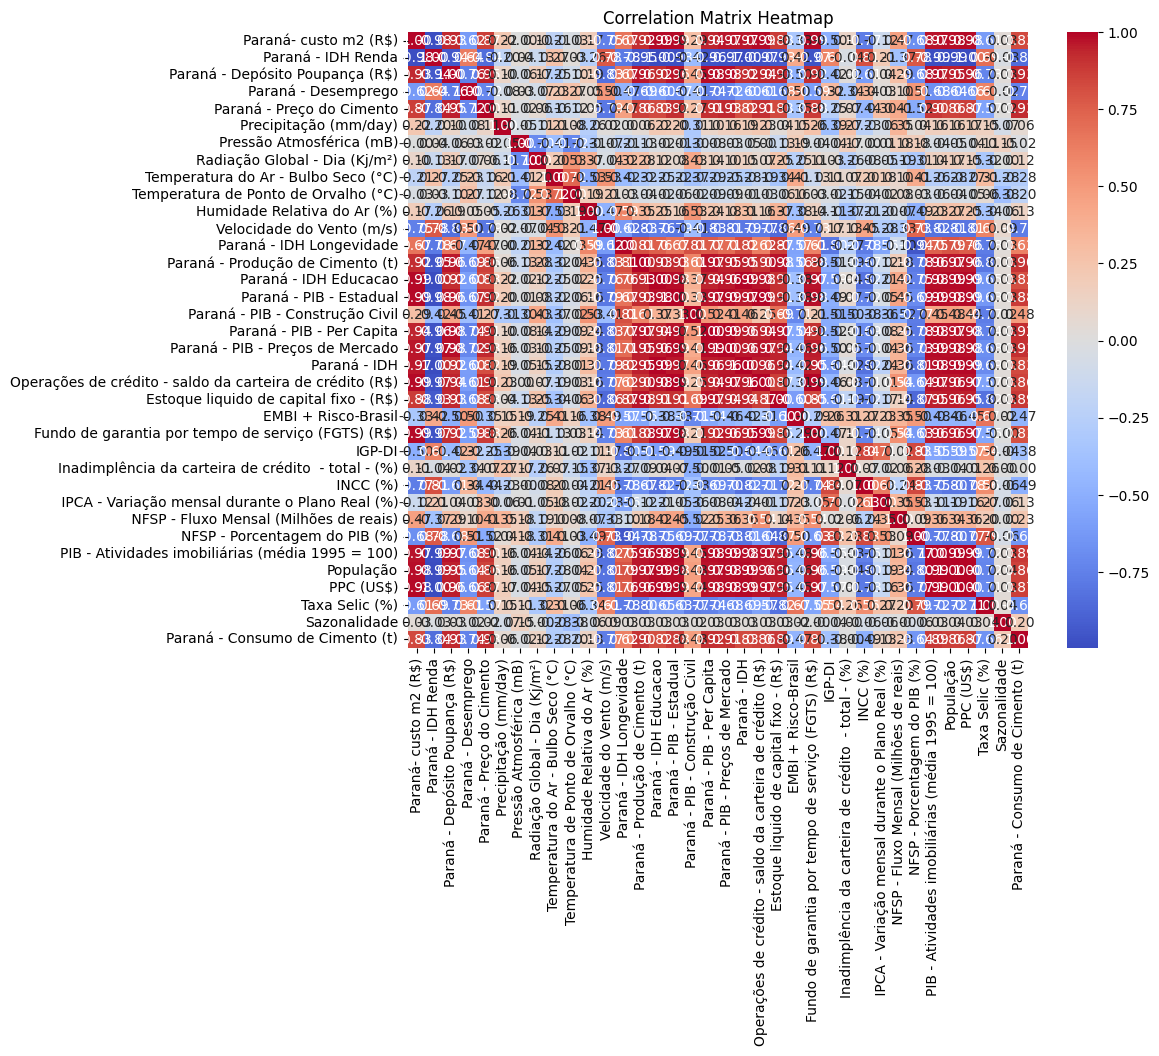

In [39]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [40]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [41]:
safe_data = data.fillna(0.0).iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

Feature           VIF
0                               Paraná- custo m2 (R$)  1.431230e+06
1                                  Paraná - IDH Renda  1.567496e+08
2                     Paraná - Depósito Poupança (R$)  3.424312e+03
3                                 Paraná - Desemprego  1.397604e+05
4                           Paraná - Preço do Cimento  1.390545e+05
5                               Precipitação (mm/day)  1.086410e+01
6                            Pressão Atmosférica (mB)  1.436414e+04
7                       Radiação Global - Dia (Kj/m²)  1.147682e+03
8                 Temperatura do Ar - Bulbo Seco (°C)  1.042661e+04
9                Temperatura de Ponto de Orvalho (°C)  5.758876e+03
10                        Humidade Relativa do Ar (%)  9.577947e+03
11                          Velocidade do Vento (m/s)  7.894076e+01
12                           Paraná - IDH Longevidade  7.460522e+08
13                   Paraná - Produção de Cimento (t)  2.448664e+03
14                              Paraná - IDH Educacao  6.771236e+05
15                            Paraná - PIB - Estadual  7.829190e+07
16                    Paraná - PIB - Construção Civil  2.655118e+08
17                          Paraná - PIB - Per Capita  8.339720e+05
18                   Paraná - PIB - Preços de Mercado  8.435721e+09
19                                       Paraná - IDH  7.316898e+04
20  Operações de crédito - saldo da carteira de cr...  1.200650e+05
21             Estoque liquido de capital fixo - (R$)  3.410040e+05
22                                EMBI + Risco-Brasil  1.091594e+03
23  Fundo de garantia por tempo de serviço (FGTS) ...  4.139266e+02
24                                             IGP-DI  1.550768e+03
25  Inadimplência da carteira de crédito  - total ...  1.270381e+02
26                                           INCC (%)  1.128834e+02
27    IPCA - Variação mensal durante o Plano Real (%)  2.261251e+02
28             NFSP - Fluxo Mensal (Milhões de reais)  8.104958e+01
29                      NFSP - Porcentagem do PIB (%)  6.540468e+03
30   PIB - Atividades imobiliárias (média 1995 = 100)  4.809306e+05
31                                          População  1.882158e+08
32                                          PPC (US$)  1.611549e+06
33                                     Taxa Selic (%)  8.310876e+00
34                                       Sazonalidade  2.149252e+00

In [42]:
data = remove_high_vif_columns(safe_data, 100000000)
data

Num columns removed: 4


Paraná- custo m2 (R$)  Paraná - IDH Renda  \
0             11767.370000            0.800130   
1             11852.421538            0.799796   
2             11934.318946            0.799462   
3             12015.342874            0.799128   
4             12093.451150            0.798794   
..                     ...                 ...   
175           26189.046646            0.758489   
176           26291.298844            0.758506   
177           26394.587455            0.758524   
178           26499.003679            0.758542   
179           26602.766675            0.758560   

     Paraná - Depósito Poupança (R$)  Paraná - Desemprego  \
0                       1.312029e+07             8.284196   
1                       1.313619e+07             8.277973   
2                       1.315208e+07             8.271750   
3                       1.316797e+07             8.265527   
4                       1.318386e+07             8.259304   
..                               ...                  ...   
175                     2.683661e+07             7.487170   
176                     2.696486e+07             7.477752   
177                     2.709311e+07             7.468333   
178                     2.722136e+07             7.458915   
179                     2.734961e+07             7.449496   

     Paraná - Preço do Cimento  Precipitação (mm/day)  \
0                     0.300568               0.000000   
1                     0.301710               0.000000   
2                     0.302645               0.000000   
3                     0.303413               0.000000   
4                     0.304034               0.000000   
..                         ...                    ...   
175                   0.400855               1.964917   
176                   0.401377               2.002672   
177                   0.401647               2.165416   
178                   0.402140               2.169362   
179                   0.402481               2.236722   

     Pressão Atmosférica (mB)  Radiação Global - Dia (Kj/m²)  \
0                    0.000000                       0.000000   
1                    0.000000                       0.000000   
2                    0.000000                       0.000000   
3                    0.000000                       0.000000   
4                    0.000000                       0.000000   
..                        ...                            ...   
175                914.006975                    1162.120506   
176                913.131668                    1199.046199   
177                912.079818                    1194.676048   
178                911.586292                    1233.562731   
179                911.321827                    1205.828220   

     Temperatura do Ar - Bulbo Seco (°C)  \
0                               0.000000   
1                               0.000000   
2                               0.000000   
3                               0.000000   
4                               0.000000   
..                                   ...   
175                            17.279060   
176                            18.103804   
177                            18.545493   
178                            19.084116   
179                            19.750074   

     Temperatura de Ponto de Orvalho (°C)  Humidade Relativa do Ar (%)  \
0                                0.000000                     0.000000   
1                                0.000000                     0.000000   
2                                0.000000                     0.000000   
3                                0.000000                     0.000000   
4                                0.000000                     0.000000   
..                                    ...                          ...   
175                             11.890180                    71.455916   
176                             12.671529                    71.331216   
177                   

In [43]:
input_data = data.iloc[:split_index + 1,1:]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

Paraná - IDH Renda  Paraná - Depósito Poupança (R$)  Paraná - Desemprego  \
0              1.928214                        -1.375577             1.135376   
1              1.901370                        -1.372732             1.121280   
2              1.874527                        -1.369888             1.107184   
3              1.847684                        -1.367043             1.093087   
4              1.820841                        -1.364199             1.078991   
..                  ...                              ...                  ...   
175           -1.418200                         1.079404            -0.670068   
176           -1.416761                         1.102358            -0.691403   
177           -1.415322                         1.125313            -0.712739   
178           -1.413884                         1.148267            -0.734074   
179           -1.412445                         1.171221            -0.755409   

     Paraná - Preço do Cimento  Precipitação (mm/day)  \
0                    -0.928691              -2.720908   
1                    -0.910659              -2.720908   
2                    -0.895896              -2.720908   
3                    -0.883769              -2.720908   
4                    -0.873955              -2.720908   
..                         ...                    ...   
175                   0.655022               0.747630   
176                   0.663269               0.814275   
177                   0.667524               1.101557   
178                   0.675307               1.108523   
179                   0.680702               1.227429   

     Pressão Atmosférica (mB)  Radiação Global - Dia (Kj/m²)  \
0                   -3.741616                      -3.553506   
1                   -3.741616                      -3.553506   
2                   -3.741616                      -3.553506   
3                   -3.741616                      -3.553506   
4                   -3.741616                      -3.553506   
..                        ...                            ...   
175                  0.272090                       0.255423   
176                  0.268246                       0.376450   
177                  0.263627                       0.362126   
178                  0.261460                       0.489580   
179                  0.260298                       0.398678   

     Temperatura do Ar - Bulbo Seco (°C)  \
0                              -3.463290   
1                              -3.463290   
2                              -3.463290   
3                              -3.463290   
4                              -3.463290   
..                                   ...   
175                             0.034626   
176                             0.201584   
177                             0.290998   
178                             0.400035   
179                             0.534850   

     Temperatura de Ponto de Orvalho (°C)  Humidade Relativa do Ar (%)  \
0                               -3.374470                    -3.589078   
1                               -3.374470                    -3.589078   
2                               -3.374470                    -3.589078   
3                               -3.374470                    -3.589078   
4                               -3.374470                    -3.589078   
..                                    ...                          ...   
175                             -0.102786                     0.118809   
176                              0.112209                     0.112338   
177                              0.312185                     0.136328   
178                              0.471929                     0.149749   
179                              0.750437                     0.187651   

     Velocidade do Vento (m/s)  Paraná - IDH Longevidade  \
0                    -3.194276                 -3.026166   
1                    -3.194276          

In [44]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

Paraná - IDH Renda  Paraná - Depósito Poupança (R$)  Paraná - Desemprego  \
0              1.928214                        -1.375577             1.135376   
1              1.901370                        -1.372732             1.121280   
2              1.874527                        -1.369888             1.107184   
3              1.847684                        -1.367043             1.093087   
4              1.820841                        -1.364199             1.078991   
..                  ...                              ...                  ...   
163           -1.440446                         0.820355            -0.249301   
164           -1.438011                         0.840029            -0.303585   
165           -1.435576                         0.859702            -0.357869   
166           -1.433141                         0.879376            -0.412153   
167           -1.430706                         0.899049            -0.466437   

     Paraná - Preço do Cimento  Precipitação (mm/day)  \
0                    -0.928691              -2.720908   
1                    -0.910659              -2.720908   
2                    -0.895896              -2.720908   
3                    -0.883769              -2.720908   
4                    -0.873955              -2.720908   
..                         ...                    ...   
163                   0.595872               0.967447   
164                   0.581998               0.974761   
165                   0.572513               1.070670   
166                   0.564328               0.856242   
167                   0.567318               0.524523   

     Pressão Atmosférica (mB)  Radiação Global - Dia (Kj/m²)  \
0                   -3.741616                      -3.553506   
1                   -3.741616                      -3.553506   
2                   -3.741616                      -3.553506   
3                   -3.741616                      -3.553506   
4                   -3.741616                      -3.553506   
..                        ...                            ...   
163                  0.270518                       0.317311   
164                  0.267582                       0.406776   
165                  0.264506                       0.392378   
166                  0.262735                       0.591858   
167                  0.262551                       0.535479   

     Temperatura do Ar - Bulbo Seco (°C)  \
0                              -3.463290   
1                              -3.463290   
2                              -3.463290   
3                              -3.463290   
4                              -3.463290   
..                                   ...   
163                            -0.192889   
164                            -0.019605   
165                             0.201956   
166                             0.433667   
167                             0.568267   

     Temperatura de Ponto de Orvalho (°C)  Humidade Relativa do Ar (%)  \
0                               -3.374470                    -3.589078   
1                               -3.374470                    -3.589078   
2                               -3.374470                    -3.589078   
3                               -3.374470                    -3.589078   
4                               -3.374470                    -3.589078   
..                                    ...                          ...   
163                             -0.276814                     0.233239   
164                             -0.046429                     0.229961   
165                              0.316419                     0.272031   
166                              0.577645                     0.239802   
167                              0.784260                     0.253118   

     Velocidade do Vento (m/s)  Paraná - IDH Longevidade  \
0                    -3.194276                 -3.026166   
1                    -3.194276          

In [45]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      172.044
1      188.841
2      200.253
3      188.916
4      184.994
        ...   
163    344.937
164    302.082
165    294.467
166    336.029
167    278.117
Name: Paraná - Consumo de Cimento (t), Length: 168, dtype: float64

In [46]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

Paraná - IDH Renda  Paraná - Depósito Poupança (R$)  Paraná - Desemprego  \
168           -1.428271                         0.918723            -0.520721   
169           -1.426833                         0.941677            -0.542057   
170           -1.425394                         0.964632            -0.563392   
171           -1.423955                         0.987586            -0.584727   
172           -1.422516                         1.010541            -0.606062   
173           -1.421077                         1.033495            -0.627398   
174           -1.419639                         1.056449            -0.648733   
175           -1.418200                         1.079404            -0.670068   
176           -1.416761                         1.102358            -0.691403   
177           -1.415322                         1.125313            -0.712739   
178           -1.413884                         1.148267            -0.734074   
179           -1.412445                         1.171221            -0.755409   

     Paraná - Preço do Cimento  Precipitação (mm/day)  \
168                   0.575394               0.383088   
169                   0.585231               0.123406   
170                   0.594961               0.298512   
171                   0.608940               0.145735   
172                   0.620765               0.209433   
173                   0.631999               0.265975   
174                   0.646022               0.086580   
175                   0.655022               0.747630   
176                   0.663269               0.814275   
177                   0.667524               1.101557   
178                   0.675307               1.108523   
179                   0.680702               1.227429   

     Pressão Atmosférica (mB)  Radiação Global - Dia (Kj/m²)  \
168                  0.263892                       0.470131   
169                  0.265579                       0.292351   
170                  0.268639                       0.006727   
171                  0.273988                      -0.018703   
172                  0.276211                      -0.080956   
173                  0.278835                       0.070059   
174                  0.277707                       0.133173   
175                  0.272090                       0.255423   
176                  0.268246                       0.376450   
177                  0.263627                       0.362126   
178                  0.261460                       0.489580   
179                  0.260298                       0.398678   

     Temperatura do Ar - Bulbo Seco (°C)  \
168                             0.562371   
169                             0.469222   
170                             0.254958   
171                             0.042994   
172                            -0.098146   
173                            -0.108885   
174                            -0.074878   
175                             0.034626   
176                             0.201584   
177                             0.290998   
178                             0.400035   
179                             0.534850   

     Temperatura de Ponto de Orvalho (°C)  Humidade Relativa do Ar (%)  \
168                              0.820782                     0.277107   
169                              0.740087                     0.306293   
170                              0.492956                     0.322247   
171                              0.180219                     0.289593   
172                             -0.043526                     0.260074   
173                             -0.203906                     0.170999   
174                             -0.191925                     0.143186   
175                             -0.102786                     0.118809   
176                              0.112209                     0.112338   
177                              0.312185                     0

In [47]:
# Alvo para teste
test_target = target_data.iloc[train_split - window_size:split_index + 1]
test_target

168    323.005
169    291.453
170    300.203
171    317.058
172    314.142
173    301.878
174    358.797
175    356.169
176    316.188
177    346.214
178    323.401
179    238.466
Name: Paraná - Consumo de Cimento (t), dtype: float64

In [48]:
# Rede neural feed-forward com optmizador Estocástico
def neural_network_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation='tanh', kernel_regularizer=regularizers.l2(0.01), 
                              input_shape=(train_input.shape[1],)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(128, activation='tanh', kernel_regularizer=regularizers.l2(0.01)),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(32, activation='tanh', kernel_regularizer=regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer, loss='mean_squared_error')   
    history = model.fit(train_input, 
                      train_target, 
                      epochs=10000,
                      validation_split=0.07,
                      callbacks=[early_stopping], 
                      verbose=want_verbose)
    return model, history

In [49]:
winner_seed = 2812446046

In [50]:
trained_model, history = neural_network_model(train_input, train_target, want_verbose=1, seed=winner_seed)
# 2812446046

Epoch 1/10000
5/5 [==============================] - 1s 22ms/step - loss: 88998.5312 - val_loss: 53691.8867
Epoch 2/10000
5/5 [==============================] - 0s 4ms/step - loss: 58916.1406 - val_loss: 117965.9297
Epoch 3/10000
5/5 [==============================] - 0s 4ms/step - loss: 32657.0215 - val_loss: 43934.2031
Epoch 4/10000
5/5 [==============================] - 0s 4ms/step - loss: 43220.7422 - val_loss: 92703.1016
Epoch 5/10000
5/5 [==============================] - 0s 4ms/step - loss: 32227.2598 - val_loss: 36331.4531
Epoch 6/10000
5/5 [==============================] - 0s 5ms/step - loss: 26672.4492 - val_loss: 6757.7573
Epoch 7/10000
5/5 [==============================] - 0s 4ms/step - loss: 22339.4883 - val_loss: 36227.5078
Epoch 8/10000
5/5 [==============================] - 0s 4ms/step - loss: 17902.5820 - val_loss: 6918.7368
Epoch 9/10000
5/5 [==============================] - 0s 5ms/step - loss: 18293.1895 - val_loss: 34444.8555
Epoch 10/10000
5/5 [=================

5/5 [==============================] - 0s 4ms/step - loss: 3866.6082 - val_loss: 7301.2993
Epoch 79/10000
5/5 [==============================] - 0s 4ms/step - loss: 3622.1455 - val_loss: 3871.8787
Epoch 80/10000
5/5 [==============================] - 0s 4ms/step - loss: 3584.3486 - val_loss: 3875.8633
Epoch 81/10000
5/5 [==============================] - 0s 4ms/step - loss: 3247.1111 - val_loss: 3146.2122
Epoch 82/10000
5/5 [==============================] - 0s 4ms/step - loss: 3420.4570 - val_loss: 3094.0930
Epoch 83/10000
5/5 [==============================] - 0s 4ms/step - loss: 3718.0442 - val_loss: 3287.8757
Epoch 84/10000
5/5 [==============================] - 0s 4ms/step - loss: 3444.7932 - val_loss: 4011.3328
Epoch 85/10000
5/5 [==============================] - 0s 4ms/step - loss: 3856.1077 - val_loss: 3018.7742
Epoch 86/10000
5/5 [==============================] - 0s 4ms/step - loss: 3356.7629 - val_loss: 2860.6670
Epoch 87/10000
5/5 [==============================] - 0s 4ms/

Epoch 155/10000
5/5 [==============================] - 0s 4ms/step - loss: 2806.7395 - val_loss: 3171.4766
Epoch 156/10000
5/5 [==============================] - 0s 4ms/step - loss: 2765.6926 - val_loss: 3190.2307
Epoch 157/10000
5/5 [==============================] - 0s 4ms/step - loss: 2731.6853 - val_loss: 3171.3562
Epoch 158/10000
5/5 [==============================] - 0s 4ms/step - loss: 2789.2356 - val_loss: 3199.3311
Epoch 159/10000
5/5 [==============================] - 0s 4ms/step - loss: 2812.8044 - val_loss: 3230.0020
Epoch 160/10000
5/5 [==============================] - 0s 4ms/step - loss: 2858.7249 - val_loss: 3300.7981
Epoch 161/10000
5/5 [==============================] - 0s 4ms/step - loss: 2772.0637 - val_loss: 3325.7532
Epoch 162/10000
5/5 [==============================] - 0s 4ms/step - loss: 2874.3445 - val_loss: 3321.1692
Epoch 163/10000
5/5 [==============================] - 0s 4ms/step - loss: 2802.1267 - val_loss: 3237.1042
Epoch 164/10000
5/5 [================

5/5 [==============================] - 0s 4ms/step - loss: 3265.3320 - val_loss: 4601.4121
Epoch 232/10000
5/5 [==============================] - 0s 4ms/step - loss: 3509.4817 - val_loss: 4056.0403
Epoch 233/10000
5/5 [==============================] - 0s 4ms/step - loss: 3788.0032 - val_loss: 3195.9561
Epoch 234/10000
5/5 [==============================] - 0s 4ms/step - loss: 3281.1311 - val_loss: 3151.5012
Epoch 235/10000
5/5 [==============================] - 0s 4ms/step - loss: 2977.3528 - val_loss: 3141.6279
Epoch 236/10000
5/5 [==============================] - 0s 4ms/step - loss: 2943.7441 - val_loss: 3141.1328
Epoch 237/10000
5/5 [==============================] - 0s 4ms/step - loss: 2748.4607 - val_loss: 3136.6409
Epoch 238/10000
5/5 [==============================] - 0s 4ms/step - loss: 2792.9485 - val_loss: 3165.4519
Epoch 239/10000
5/5 [==============================] - 0s 4ms/step - loss: 2787.6758 - val_loss: 3192.0359
Epoch 240/10000
5/5 [==============================] 

5/5 [==============================] - 0s 4ms/step - loss: 2648.8901 - val_loss: 3061.6433
Epoch 308/10000
5/5 [==============================] - 0s 4ms/step - loss: 2773.2620 - val_loss: 3681.3760
Epoch 309/10000
5/5 [==============================] - 0s 4ms/step - loss: 2803.7932 - val_loss: 3440.0107
Epoch 310/10000
5/5 [==============================] - 0s 4ms/step - loss: 2777.9072 - val_loss: 3306.9541
Epoch 311/10000
5/5 [==============================] - 0s 4ms/step - loss: 2755.1194 - val_loss: 3338.7083
Epoch 312/10000
5/5 [==============================] - 0s 4ms/step - loss: 2751.1047 - val_loss: 3238.0383
Epoch 313/10000
5/5 [==============================] - 0s 4ms/step - loss: 2613.8208 - val_loss: 3136.2107
Epoch 314/10000
5/5 [==============================] - 0s 4ms/step - loss: 2659.5542 - val_loss: 3100.5850
Epoch 315/10000
5/5 [==============================] - 0s 4ms/step - loss: 2611.6863 - val_loss: 3134.1611
Epoch 316/10000
5/5 [==============================] 

5/5 [==============================] - 0s 4ms/step - loss: 2519.9080 - val_loss: 3261.6025
Epoch 384/10000
5/5 [==============================] - 0s 4ms/step - loss: 2509.3057 - val_loss: 3173.8799
Epoch 385/10000
5/5 [==============================] - 0s 4ms/step - loss: 2592.1187 - val_loss: 3115.2400
Epoch 386/10000
5/5 [==============================] - 0s 4ms/step - loss: 2582.0920 - val_loss: 3159.7371
Epoch 387/10000
5/5 [==============================] - 0s 4ms/step - loss: 2492.6970 - val_loss: 3100.8020
Epoch 388/10000
5/5 [==============================] - 0s 4ms/step - loss: 2512.9287 - val_loss: 3108.7012
Epoch 389/10000
5/5 [==============================] - 0s 4ms/step - loss: 2516.8616 - val_loss: 3081.5479
Epoch 390/10000
5/5 [==============================] - 0s 4ms/step - loss: 2477.9507 - val_loss: 3141.3528
Epoch 391/10000
5/5 [==============================] - 0s 4ms/step - loss: 2430.6870 - val_loss: 3237.3059
Epoch 392/10000
5/5 [==============================] 

5/5 [==============================] - 0s 4ms/step - loss: 2352.7068 - val_loss: 2941.9890
Epoch 460/10000
5/5 [==============================] - 0s 4ms/step - loss: 2369.3196 - val_loss: 2970.9055
Epoch 461/10000
5/5 [==============================] - 0s 4ms/step - loss: 2301.2517 - val_loss: 2949.4368
Epoch 462/10000
5/5 [==============================] - 0s 4ms/step - loss: 2355.2451 - val_loss: 2946.2429
Epoch 463/10000
5/5 [==============================] - 0s 4ms/step - loss: 2375.7307 - val_loss: 2937.4988
Epoch 464/10000
5/5 [==============================] - 0s 4ms/step - loss: 2386.9045 - val_loss: 2922.7483
Epoch 465/10000
5/5 [==============================] - 0s 4ms/step - loss: 2353.1780 - val_loss: 3241.9089
Epoch 466/10000
5/5 [==============================] - 0s 4ms/step - loss: 2338.4912 - val_loss: 2915.8440
Epoch 467/10000
5/5 [==============================] - 0s 4ms/step - loss: 2346.0420 - val_loss: 2914.4421
Epoch 468/10000
5/5 [==============================] 

5/5 [==============================] - 0s 4ms/step - loss: 2255.1426 - val_loss: 2859.7307
Epoch 536/10000
5/5 [==============================] - 0s 4ms/step - loss: 2227.4231 - val_loss: 2845.3613
Epoch 537/10000
5/5 [==============================] - 0s 4ms/step - loss: 2245.4895 - val_loss: 2843.3235
Epoch 538/10000
5/5 [==============================] - 0s 4ms/step - loss: 2256.1113 - val_loss: 2845.5330
Epoch 539/10000
5/5 [==============================] - 0s 4ms/step - loss: 2233.8811 - val_loss: 2861.1289
Epoch 540/10000
5/5 [==============================] - 0s 4ms/step - loss: 2221.2920 - val_loss: 2858.7510
Epoch 541/10000
5/5 [==============================] - 0s 4ms/step - loss: 2291.3855 - val_loss: 2853.0154
Epoch 542/10000
5/5 [==============================] - 0s 4ms/step - loss: 2346.1541 - val_loss: 2789.3816
Epoch 543/10000
5/5 [==============================] - 0s 4ms/step - loss: 2281.7554 - val_loss: 3172.9324
Epoch 544/10000
5/5 [==============================] 

5/5 [==============================] - 0s 4ms/step - loss: 2112.4900 - val_loss: 2751.9851
Epoch 612/10000
5/5 [==============================] - 0s 4ms/step - loss: 2112.9475 - val_loss: 2757.5852
Epoch 613/10000
5/5 [==============================] - 0s 4ms/step - loss: 2192.1758 - val_loss: 2764.9746
Epoch 614/10000
5/5 [==============================] - 0s 4ms/step - loss: 2170.6511 - val_loss: 2764.8040
Epoch 615/10000
5/5 [==============================] - 0s 4ms/step - loss: 2207.8423 - val_loss: 2761.7976
Epoch 616/10000
5/5 [==============================] - 0s 4ms/step - loss: 2206.4246 - val_loss: 2770.1902
Epoch 617/10000
5/5 [==============================] - 0s 4ms/step - loss: 2204.9348 - val_loss: 2786.3757
Epoch 618/10000
5/5 [==============================] - 0s 4ms/step - loss: 2200.7886 - val_loss: 2764.7527
Epoch 619/10000
5/5 [==============================] - 0s 4ms/step - loss: 2153.5195 - val_loss: 2775.0066
Epoch 620/10000
5/5 [==============================] 

5/5 [==============================] - 0s 4ms/step - loss: 2035.2275 - val_loss: 2722.7354
Epoch 688/10000
5/5 [==============================] - 0s 4ms/step - loss: 2065.5698 - val_loss: 2690.5073
Epoch 689/10000
5/5 [==============================] - 0s 4ms/step - loss: 2078.0850 - val_loss: 2653.9956
Epoch 690/10000
5/5 [==============================] - 0s 4ms/step - loss: 2020.2090 - val_loss: 2661.4917
Epoch 691/10000
5/5 [==============================] - 0s 4ms/step - loss: 2002.2769 - val_loss: 2669.0271
Epoch 692/10000
5/5 [==============================] - 0s 4ms/step - loss: 2004.3250 - val_loss: 2750.4736
Epoch 693/10000
5/5 [==============================] - 0s 4ms/step - loss: 2052.2490 - val_loss: 2716.6897
Epoch 694/10000
5/5 [==============================] - 0s 4ms/step - loss: 2013.2272 - val_loss: 2554.9517
Epoch 695/10000
5/5 [==============================] - 0s 4ms/step - loss: 2028.1010 - val_loss: 2730.1216
Epoch 696/10000
5/5 [==============================] 

5/5 [==============================] - 0s 4ms/step - loss: 1932.0593 - val_loss: 2658.8154
Epoch 764/10000
5/5 [==============================] - 0s 4ms/step - loss: 1911.8931 - val_loss: 2649.9438
Epoch 765/10000
5/5 [==============================] - 0s 4ms/step - loss: 1946.1294 - val_loss: 2647.8784
Epoch 766/10000
5/5 [==============================] - 0s 4ms/step - loss: 1887.9807 - val_loss: 2624.8855
Epoch 767/10000
5/5 [==============================] - 0s 4ms/step - loss: 1908.7972 - val_loss: 2629.7771
Epoch 768/10000
5/5 [==============================] - 0s 4ms/step - loss: 1917.5587 - val_loss: 2642.9873
Epoch 769/10000
5/5 [==============================] - 0s 4ms/step - loss: 1910.6783 - val_loss: 2616.1289
Epoch 770/10000
5/5 [==============================] - 0s 4ms/step - loss: 1904.3563 - val_loss: 2646.6301
Epoch 771/10000
5/5 [==============================] - 0s 4ms/step - loss: 1939.0316 - val_loss: 2655.5938
Epoch 772/10000
5/5 [==============================] 

5/5 [==============================] - 0s 4ms/step - loss: 1866.4121 - val_loss: 2569.1333
Epoch 840/10000
5/5 [==============================] - 0s 4ms/step - loss: 1850.7178 - val_loss: 2545.9761
Epoch 841/10000
5/5 [==============================] - 0s 4ms/step - loss: 1844.4866 - val_loss: 2557.8071
Epoch 842/10000
5/5 [==============================] - 0s 4ms/step - loss: 1803.1342 - val_loss: 2530.5776
Epoch 843/10000
5/5 [==============================] - 0s 4ms/step - loss: 1847.3822 - val_loss: 2536.0015
Epoch 844/10000
5/5 [==============================] - 0s 4ms/step - loss: 1807.7957 - val_loss: 2546.1323
Epoch 845/10000
5/5 [==============================] - 0s 4ms/step - loss: 1829.7172 - val_loss: 2513.1953
Epoch 846/10000
5/5 [==============================] - 0s 4ms/step - loss: 1843.6493 - val_loss: 2501.3149
Epoch 847/10000
5/5 [==============================] - 0s 4ms/step - loss: 1811.4150 - val_loss: 2532.4644
Epoch 848/10000
5/5 [==============================] 

5/5 [==============================] - 0s 4ms/step - loss: 1774.5663 - val_loss: 2432.6631
Epoch 916/10000
5/5 [==============================] - 0s 4ms/step - loss: 1709.9043 - val_loss: 2460.0894
Epoch 917/10000
5/5 [==============================] - 0s 5ms/step - loss: 1749.3987 - val_loss: 2483.6523
Epoch 918/10000
5/5 [==============================] - 0s 5ms/step - loss: 1715.6810 - val_loss: 2511.3406
Epoch 919/10000
5/5 [==============================] - 0s 4ms/step - loss: 1725.6440 - val_loss: 2321.2466
Epoch 920/10000
5/5 [==============================] - 0s 4ms/step - loss: 1691.6490 - val_loss: 2521.9866
Epoch 921/10000
5/5 [==============================] - 0s 4ms/step - loss: 1697.0531 - val_loss: 2516.1785
Epoch 922/10000
5/5 [==============================] - 0s 4ms/step - loss: 1699.2616 - val_loss: 2503.0847
Epoch 923/10000
5/5 [==============================] - 0s 4ms/step - loss: 1673.2493 - val_loss: 2700.8418
Epoch 924/10000
5/5 [==============================] 

5/5 [==============================] - 0s 4ms/step - loss: 1655.6526 - val_loss: 2311.5439
Epoch 992/10000
5/5 [==============================] - 0s 4ms/step - loss: 1672.3846 - val_loss: 2304.1914
Epoch 993/10000
5/5 [==============================] - 0s 4ms/step - loss: 1613.8416 - val_loss: 2296.7729
Epoch 994/10000
5/5 [==============================] - 0s 5ms/step - loss: 1665.6779 - val_loss: 2312.4487
Epoch 995/10000
5/5 [==============================] - 0s 4ms/step - loss: 1634.0647 - val_loss: 2308.6584
Epoch 996/10000
5/5 [==============================] - 0s 4ms/step - loss: 1645.7197 - val_loss: 2300.2473
Epoch 997/10000
5/5 [==============================] - 0s 4ms/step - loss: 1681.9163 - val_loss: 2339.4199
Epoch 998/10000
5/5 [==============================] - 0s 4ms/step - loss: 1714.6041 - val_loss: 2301.4990
Epoch 999/10000
5/5 [==============================] - 0s 4ms/step - loss: 1673.2957 - val_loss: 2303.2705
Epoch 1000/10000
5/5 [==============================]

5/5 [==============================] - 0s 4ms/step - loss: 1576.0497 - val_loss: 2208.0491
Epoch 1068/10000
5/5 [==============================] - 0s 4ms/step - loss: 1533.3081 - val_loss: 2216.7852
Epoch 1069/10000
5/5 [==============================] - 0s 4ms/step - loss: 1524.8837 - val_loss: 2211.7351
Epoch 1070/10000
5/5 [==============================] - 0s 4ms/step - loss: 1506.0845 - val_loss: 2208.4851
Epoch 1071/10000
5/5 [==============================] - 0s 4ms/step - loss: 1614.0627 - val_loss: 2210.3813
Epoch 1072/10000
5/5 [==============================] - 0s 4ms/step - loss: 1539.6858 - val_loss: 2211.3062
Epoch 1073/10000
5/5 [==============================] - 0s 4ms/step - loss: 1543.3750 - val_loss: 2215.9131
Epoch 1074/10000
5/5 [==============================] - 0s 4ms/step - loss: 1619.6053 - val_loss: 2210.0889
Epoch 1075/10000
5/5 [==============================] - 0s 5ms/step - loss: 1498.0695 - val_loss: 2223.5610
Epoch 1076/10000
5/5 [=======================

5/5 [==============================] - 0s 4ms/step - loss: 1489.5074 - val_loss: 3077.9221
Epoch 1144/10000
5/5 [==============================] - 0s 4ms/step - loss: 1487.5377 - val_loss: 2093.6006
Epoch 1145/10000
5/5 [==============================] - 0s 4ms/step - loss: 1522.7615 - val_loss: 2198.4053
Epoch 1146/10000
5/5 [==============================] - 0s 4ms/step - loss: 1497.6927 - val_loss: 2155.1528
Epoch 1147/10000
5/5 [==============================] - 0s 4ms/step - loss: 1414.7070 - val_loss: 2146.2144
Epoch 1148/10000
5/5 [==============================] - 0s 4ms/step - loss: 1493.3726 - val_loss: 2049.2693
Epoch 1149/10000
5/5 [==============================] - 0s 4ms/step - loss: 1453.0323 - val_loss: 2067.3542
Epoch 1150/10000
5/5 [==============================] - 0s 4ms/step - loss: 1431.1923 - val_loss: 2106.5974
Epoch 1151/10000
5/5 [==============================] - 0s 4ms/step - loss: 1527.7551 - val_loss: 2219.8464
Epoch 1152/10000
5/5 [=======================

5/5 [==============================] - 0s 4ms/step - loss: 1423.8259 - val_loss: 2149.5549
Epoch 1220/10000
5/5 [==============================] - 0s 4ms/step - loss: 1394.0209 - val_loss: 2220.8892
Epoch 1221/10000
5/5 [==============================] - 0s 4ms/step - loss: 1436.2125 - val_loss: 2063.4092
Epoch 1222/10000
5/5 [==============================] - 0s 4ms/step - loss: 1436.9358 - val_loss: 2133.5996
Epoch 1223/10000
5/5 [==============================] - 0s 4ms/step - loss: 1404.0460 - val_loss: 2108.2439
Epoch 1224/10000
5/5 [==============================] - 0s 4ms/step - loss: 1400.2930 - val_loss: 2056.6211
Epoch 1225/10000
5/5 [==============================] - 0s 4ms/step - loss: 1444.2797 - val_loss: 2738.7112
Epoch 1226/10000
5/5 [==============================] - 0s 4ms/step - loss: 1411.4825 - val_loss: 2782.3821
Epoch 1227/10000
5/5 [==============================] - 0s 4ms/step - loss: 1537.7085 - val_loss: 2117.4116
Epoch 1228/10000
5/5 [=======================

5/5 [==============================] - 0s 4ms/step - loss: 1381.4263 - val_loss: 2114.1367
Epoch 1296/10000
5/5 [==============================] - 0s 4ms/step - loss: 1525.3502 - val_loss: 2108.9321
Epoch 1297/10000
5/5 [==============================] - 0s 4ms/step - loss: 1380.0410 - val_loss: 2226.1802
Epoch 1298/10000
5/5 [==============================] - 0s 4ms/step - loss: 1395.8967 - val_loss: 2182.3096
Epoch 1299/10000
5/5 [==============================] - 0s 4ms/step - loss: 1429.0903 - val_loss: 2509.7251
Epoch 1300/10000
5/5 [==============================] - 0s 4ms/step - loss: 1494.8463 - val_loss: 2411.4917
Epoch 1301/10000
5/5 [==============================] - 0s 4ms/step - loss: 1462.1554 - val_loss: 2264.9451
Epoch 1302/10000
5/5 [==============================] - 0s 4ms/step - loss: 1465.0587 - val_loss: 3160.5989
Epoch 1303/10000
5/5 [==============================] - 0s 4ms/step - loss: 1501.2574 - val_loss: 2978.5403
Epoch 1304/10000
5/5 [=======================

5/5 [==============================] - 0s 4ms/step - loss: 1380.2850 - val_loss: 1902.8208
Epoch 1372/10000
5/5 [==============================] - 0s 4ms/step - loss: 1326.5178 - val_loss: 2169.9521
Epoch 1373/10000
5/5 [==============================] - 0s 4ms/step - loss: 1348.1643 - val_loss: 2122.7427
Epoch 1374/10000
5/5 [==============================] - 0s 4ms/step - loss: 1355.2111 - val_loss: 2120.3611
Epoch 1375/10000
5/5 [==============================] - 0s 4ms/step - loss: 1347.8832 - val_loss: 2277.7124
Epoch 1376/10000
5/5 [==============================] - 0s 4ms/step - loss: 1384.0718 - val_loss: 2398.2749
Epoch 1377/10000
5/5 [==============================] - 0s 4ms/step - loss: 1340.9808 - val_loss: 1965.4926
Epoch 1378/10000
5/5 [==============================] - 0s 4ms/step - loss: 1328.7057 - val_loss: 1991.8822
Epoch 1379/10000
5/5 [==============================] - 0s 4ms/step - loss: 1404.1851 - val_loss: 1951.6500
Epoch 1380/10000
5/5 [=======================

5/5 [==============================] - 0s 4ms/step - loss: 1303.1383 - val_loss: 1884.1493
Epoch 1448/10000
5/5 [==============================] - 0s 4ms/step - loss: 1225.4385 - val_loss: 1882.4713
Epoch 1449/10000
5/5 [==============================] - 0s 4ms/step - loss: 1286.0847 - val_loss: 2098.9609
Epoch 1450/10000
5/5 [==============================] - 0s 4ms/step - loss: 1336.9153 - val_loss: 2350.1196
Epoch 1451/10000
5/5 [==============================] - 0s 4ms/step - loss: 1304.5282 - val_loss: 2319.3032
Epoch 1452/10000
5/5 [==============================] - 0s 4ms/step - loss: 1309.1125 - val_loss: 2207.7109
Epoch 1453/10000
5/5 [==============================] - 0s 4ms/step - loss: 1273.3752 - val_loss: 2142.5283
Epoch 1454/10000
5/5 [==============================] - 0s 4ms/step - loss: 1339.3324 - val_loss: 1955.7919
Epoch 1455/10000
5/5 [==============================] - 0s 4ms/step - loss: 1315.0743 - val_loss: 2238.1924
Epoch 1456/10000
5/5 [=======================

5/5 [==============================] - 0s 4ms/step - loss: 1253.1810 - val_loss: 2612.0620
Epoch 1524/10000
5/5 [==============================] - 0s 4ms/step - loss: 1311.9257 - val_loss: 2544.9487
Epoch 1525/10000
5/5 [==============================] - 0s 4ms/step - loss: 1200.8828 - val_loss: 2363.0891
Epoch 1526/10000
5/5 [==============================] - 0s 4ms/step - loss: 1220.4427 - val_loss: 2300.0005
Epoch 1527/10000
5/5 [==============================] - 0s 4ms/step - loss: 1259.1056 - val_loss: 2386.6987
Epoch 1528/10000
5/5 [==============================] - 0s 4ms/step - loss: 1313.8119 - val_loss: 2239.6299
Epoch 1529/10000
5/5 [==============================] - 0s 4ms/step - loss: 1278.8123 - val_loss: 2078.9980
Epoch 1530/10000
5/5 [==============================] - 0s 4ms/step - loss: 1236.8513 - val_loss: 2082.1802
Epoch 1531/10000
5/5 [==============================] - 0s 4ms/step - loss: 1282.5132 - val_loss: 2150.2820
Epoch 1532/10000
5/5 [=======================

5/5 [==============================] - 0s 4ms/step - loss: 1151.2339 - val_loss: 2080.5586
Epoch 1600/10000
5/5 [==============================] - 0s 4ms/step - loss: 1178.5536 - val_loss: 2007.8398
Epoch 1601/10000
5/5 [==============================] - 0s 4ms/step - loss: 1157.6373 - val_loss: 2093.9453
Epoch 1602/10000
5/5 [==============================] - 0s 4ms/step - loss: 1175.4902 - val_loss: 2068.1699
Epoch 1603/10000
5/5 [==============================] - 0s 4ms/step - loss: 1167.6904 - val_loss: 2002.7076
Epoch 1604/10000
5/5 [==============================] - 0s 4ms/step - loss: 1107.3893 - val_loss: 2007.8627
Epoch 1605/10000
5/5 [==============================] - 0s 4ms/step - loss: 1138.9348 - val_loss: 1993.9199
Epoch 1606/10000
5/5 [==============================] - 0s 4ms/step - loss: 1139.2522 - val_loss: 2038.8872
Epoch 1607/10000
5/5 [==============================] - 0s 4ms/step - loss: 1172.6268 - val_loss: 2095.7898
Epoch 1608/10000
5/5 [=======================

5/5 [==============================] - 0s 4ms/step - loss: 1085.0024 - val_loss: 1951.2904
Epoch 1676/10000
5/5 [==============================] - 0s 4ms/step - loss: 1085.5142 - val_loss: 1793.4215
Epoch 1677/10000
5/5 [==============================] - 0s 4ms/step - loss: 1122.0699 - val_loss: 1742.6348
Epoch 1678/10000
5/5 [==============================] - 0s 4ms/step - loss: 1089.9779 - val_loss: 2151.1797
Epoch 1679/10000
5/5 [==============================] - 0s 4ms/step - loss: 1080.3113 - val_loss: 2095.7488
Epoch 1680/10000
5/5 [==============================] - 0s 4ms/step - loss: 1073.3064 - val_loss: 2181.5728
Epoch 1681/10000
5/5 [==============================] - 0s 4ms/step - loss: 1130.8806 - val_loss: 2065.1658
Epoch 1682/10000
5/5 [==============================] - 0s 4ms/step - loss: 1091.9987 - val_loss: 2067.8047
Epoch 1683/10000
5/5 [==============================] - 0s 4ms/step - loss: 1088.6395 - val_loss: 2060.4248
Epoch 1684/10000
5/5 [=======================

5/5 [==============================] - 0s 4ms/step - loss: 987.2800 - val_loss: 1671.1405
Epoch 1752/10000
5/5 [==============================] - 0s 4ms/step - loss: 1025.8591 - val_loss: 1737.9408
Epoch 1753/10000
5/5 [==============================] - 0s 4ms/step - loss: 1019.7767 - val_loss: 1619.3921
Epoch 1754/10000
5/5 [==============================] - 0s 5ms/step - loss: 1025.4979 - val_loss: 1551.0039
Epoch 1755/10000
5/5 [==============================] - 0s 4ms/step - loss: 1081.8396 - val_loss: 1664.7374
Epoch 1756/10000
5/5 [==============================] - 0s 4ms/step - loss: 1070.9672 - val_loss: 1666.3383
Epoch 1757/10000
5/5 [==============================] - 0s 4ms/step - loss: 1022.1204 - val_loss: 1662.1989
Epoch 1758/10000
5/5 [==============================] - 0s 4ms/step - loss: 1052.3575 - val_loss: 1874.2067
Epoch 1759/10000
5/5 [==============================] - 0s 4ms/step - loss: 1061.5530 - val_loss: 1974.6019
Epoch 1760/10000
5/5 [========================

5/5 [==============================] - 0s 4ms/step - loss: 1022.9108 - val_loss: 1766.6920
Epoch 1828/10000
5/5 [==============================] - 0s 4ms/step - loss: 1002.0677 - val_loss: 1870.6323
Epoch 1829/10000
5/5 [==============================] - 0s 4ms/step - loss: 1040.9377 - val_loss: 1717.7328
Epoch 1830/10000
5/5 [==============================] - 0s 4ms/step - loss: 1028.7208 - val_loss: 1720.5873
Epoch 1831/10000
5/5 [==============================] - 0s 4ms/step - loss: 1108.0422 - val_loss: 1714.9482
Epoch 1832/10000
5/5 [==============================] - 0s 4ms/step - loss: 1032.0243 - val_loss: 1930.9292
Epoch 1833/10000
5/5 [==============================] - 0s 4ms/step - loss: 990.2711 - val_loss: 2054.7561
Epoch 1834/10000
5/5 [==============================] - 0s 4ms/step - loss: 1022.2432 - val_loss: 1958.8207
Epoch 1835/10000
5/5 [==============================] - 0s 4ms/step - loss: 1018.3147 - val_loss: 1759.5323
Epoch 1836/10000
5/5 [========================

5/5 [==============================] - 0s 4ms/step - loss: 1022.9313 - val_loss: 1746.3394
Epoch 1904/10000
5/5 [==============================] - 0s 4ms/step - loss: 952.8032 - val_loss: 1822.2094
Epoch 1905/10000
5/5 [==============================] - 0s 4ms/step - loss: 1055.1506 - val_loss: 1732.2842
Epoch 1906/10000
5/5 [==============================] - 0s 4ms/step - loss: 1071.9022 - val_loss: 1789.1997
Epoch 1907/10000
5/5 [==============================] - 0s 4ms/step - loss: 1044.1433 - val_loss: 1977.5189
Epoch 1908/10000
5/5 [==============================] - 0s 5ms/step - loss: 1031.3624 - val_loss: 1680.9449
Epoch 1909/10000
5/5 [==============================] - 0s 5ms/step - loss: 1005.4431 - val_loss: 1727.2191
Epoch 1910/10000
5/5 [==============================] - 0s 4ms/step - loss: 998.2900 - val_loss: 1734.8882
Epoch 1911/10000
5/5 [==============================] - 0s 4ms/step - loss: 1042.9154 - val_loss: 1704.7067
Epoch 1912/10000
5/5 [=========================

5/5 [==============================] - 0s 4ms/step - loss: 1011.1980 - val_loss: 1734.0084
Epoch 1980/10000
5/5 [==============================] - 0s 4ms/step - loss: 992.9396 - val_loss: 1720.6842
Epoch 1981/10000
5/5 [==============================] - 0s 4ms/step - loss: 972.0126 - val_loss: 2128.8188
Epoch 1982/10000
5/5 [==============================] - 0s 4ms/step - loss: 991.2596 - val_loss: 1937.8541
Epoch 1983/10000
5/5 [==============================] - 0s 4ms/step - loss: 977.3832 - val_loss: 1820.8773
Epoch 1984/10000
5/5 [==============================] - 0s 4ms/step - loss: 966.1408 - val_loss: 1991.7018
Epoch 1985/10000
5/5 [==============================] - 0s 4ms/step - loss: 989.2514 - val_loss: 1792.4536
Epoch 1986/10000
5/5 [==============================] - 0s 4ms/step - loss: 1005.4554 - val_loss: 1553.9888
Epoch 1987/10000
5/5 [==============================] - 0s 4ms/step - loss: 952.2606 - val_loss: 1620.5446
Epoch 1988/10000
5/5 [==============================

5/5 [==============================] - 0s 4ms/step - loss: 918.9446 - val_loss: 1720.3029
Epoch 2056/10000
5/5 [==============================] - 0s 4ms/step - loss: 923.4847 - val_loss: 1679.7689
Epoch 2057/10000
5/5 [==============================] - 0s 4ms/step - loss: 950.5964 - val_loss: 1558.5537
Epoch 2058/10000
5/5 [==============================] - 0s 4ms/step - loss: 904.6688 - val_loss: 1620.4482
Epoch 2059/10000
5/5 [==============================] - 0s 4ms/step - loss: 964.3386 - val_loss: 1824.2793
Epoch 2060/10000
5/5 [==============================] - 0s 4ms/step - loss: 951.1965 - val_loss: 1741.9576
Epoch 2061/10000
5/5 [==============================] - 0s 4ms/step - loss: 925.1951 - val_loss: 1728.7162
Epoch 2062/10000
5/5 [==============================] - 0s 4ms/step - loss: 952.2042 - val_loss: 1718.6654
Epoch 2063/10000
5/5 [==============================] - 0s 4ms/step - loss: 952.7556 - val_loss: 1792.9442
Epoch 2064/10000
5/5 [==============================] 

5/5 [==============================] - 0s 4ms/step - loss: 916.0047 - val_loss: 1644.0480
Epoch 2132/10000
5/5 [==============================] - 0s 4ms/step - loss: 873.2392 - val_loss: 1644.1810
Epoch 2133/10000
5/5 [==============================] - 0s 4ms/step - loss: 872.2454 - val_loss: 1593.6840
Epoch 2134/10000
5/5 [==============================] - 0s 4ms/step - loss: 860.3140 - val_loss: 1528.4683
Epoch 2135/10000
5/5 [==============================] - 0s 4ms/step - loss: 842.8444 - val_loss: 1570.9916
Epoch 2136/10000
5/5 [==============================] - 0s 4ms/step - loss: 840.3083 - val_loss: 1574.9213
Epoch 2137/10000
5/5 [==============================] - 0s 4ms/step - loss: 849.5942 - val_loss: 1498.7601
Epoch 2138/10000
5/5 [==============================] - 0s 4ms/step - loss: 837.1115 - val_loss: 1542.1836
Epoch 2139/10000
5/5 [==============================] - 0s 4ms/step - loss: 843.7322 - val_loss: 1487.0834
Epoch 2140/10000
5/5 [==============================] 

5/5 [==============================] - 0s 5ms/step - loss: 842.2004 - val_loss: 1962.2269
Epoch 2208/10000
5/5 [==============================] - 0s 5ms/step - loss: 863.7347 - val_loss: 1977.3351
Epoch 2209/10000
5/5 [==============================] - 0s 4ms/step - loss: 857.9167 - val_loss: 1990.2914
Epoch 2210/10000
5/5 [==============================] - 0s 4ms/step - loss: 880.5300 - val_loss: 2065.2471
Epoch 2211/10000
5/5 [==============================] - 0s 4ms/step - loss: 865.7302 - val_loss: 1953.1847
Epoch 2212/10000
5/5 [==============================] - 0s 4ms/step - loss: 853.2640 - val_loss: 1912.4525
Epoch 2213/10000
5/5 [==============================] - 0s 4ms/step - loss: 872.2025 - val_loss: 1886.7338
Epoch 2214/10000
5/5 [==============================] - 0s 4ms/step - loss: 858.6239 - val_loss: 1508.9619
Epoch 2215/10000
5/5 [==============================] - 0s 4ms/step - loss: 864.1627 - val_loss: 1650.6849
Epoch 2216/10000
5/5 [==============================] 

5/5 [==============================] - 0s 4ms/step - loss: 789.9882 - val_loss: 1474.8522
Epoch 2284/10000
5/5 [==============================] - 0s 4ms/step - loss: 806.1506 - val_loss: 1506.2985
Epoch 2285/10000
5/5 [==============================] - 0s 4ms/step - loss: 790.3935 - val_loss: 1566.4111
Epoch 2286/10000
5/5 [==============================] - 0s 4ms/step - loss: 817.8375 - val_loss: 1494.1206
Epoch 2287/10000
5/5 [==============================] - 0s 4ms/step - loss: 799.8072 - val_loss: 1469.7477
Epoch 2288/10000
5/5 [==============================] - 0s 4ms/step - loss: 796.1557 - val_loss: 1716.6010
Epoch 2289/10000
5/5 [==============================] - 0s 4ms/step - loss: 844.3575 - val_loss: 1426.5114
Epoch 2290/10000
5/5 [==============================] - 0s 4ms/step - loss: 818.4761 - val_loss: 1409.6456
Epoch 2291/10000
5/5 [==============================] - 0s 4ms/step - loss: 815.4379 - val_loss: 1413.6050
Epoch 2292/10000
5/5 [==============================] 

5/5 [==============================] - 0s 4ms/step - loss: 772.8034 - val_loss: 1614.6732
Epoch 2360/10000
5/5 [==============================] - 0s 4ms/step - loss: 801.9870 - val_loss: 1620.8403
Epoch 2361/10000
5/5 [==============================] - 0s 4ms/step - loss: 773.7621 - val_loss: 1608.5385
Epoch 2362/10000
5/5 [==============================] - 0s 4ms/step - loss: 807.2485 - val_loss: 1504.8607
Epoch 2363/10000
5/5 [==============================] - 0s 4ms/step - loss: 775.6623 - val_loss: 1752.3287
Epoch 2364/10000
5/5 [==============================] - 0s 4ms/step - loss: 770.0861 - val_loss: 1596.7943
Epoch 2365/10000
5/5 [==============================] - 0s 4ms/step - loss: 811.7429 - val_loss: 1586.4215
Epoch 2366/10000
5/5 [==============================] - 0s 4ms/step - loss: 777.8093 - val_loss: 1616.9086
Epoch 2367/10000
5/5 [==============================] - 0s 5ms/step - loss: 790.4418 - val_loss: 1500.7104
Epoch 2368/10000
5/5 [==============================] 

5/5 [==============================] - 0s 4ms/step - loss: 751.9028 - val_loss: 1503.2554
Epoch 2436/10000
5/5 [==============================] - 0s 4ms/step - loss: 749.0635 - val_loss: 1514.5856
Epoch 2437/10000
5/5 [==============================] - 0s 4ms/step - loss: 702.5379 - val_loss: 1728.7871
Epoch 2438/10000
5/5 [==============================] - 0s 4ms/step - loss: 708.1063 - val_loss: 1639.7070
Epoch 2439/10000
5/5 [==============================] - 0s 4ms/step - loss: 694.7043 - val_loss: 1691.2474
Epoch 2440/10000
5/5 [==============================] - 0s 4ms/step - loss: 741.0922 - val_loss: 1806.8641
Epoch 2441/10000
5/5 [==============================] - 0s 4ms/step - loss: 706.6664 - val_loss: 1840.1631
Epoch 2442/10000
5/5 [==============================] - 0s 4ms/step - loss: 717.3318 - val_loss: 1729.5221
Epoch 2443/10000
5/5 [==============================] - 0s 4ms/step - loss: 763.6497 - val_loss: 1702.9194
Epoch 2444/10000
5/5 [==============================] 

5/5 [==============================] - 0s 4ms/step - loss: 692.3314 - val_loss: 1631.2958
Epoch 2512/10000
5/5 [==============================] - 0s 5ms/step - loss: 735.3575 - val_loss: 1504.9825
Epoch 2513/10000
5/5 [==============================] - 0s 5ms/step - loss: 661.8302 - val_loss: 1548.0314
Epoch 2514/10000
5/5 [==============================] - 0s 5ms/step - loss: 695.7477 - val_loss: 1583.8114
Epoch 2515/10000
5/5 [==============================] - 0s 5ms/step - loss: 683.0983 - val_loss: 1383.2494
Epoch 2516/10000
5/5 [==============================] - 0s 5ms/step - loss: 709.3308 - val_loss: 1631.2935
Epoch 2517/10000
5/5 [==============================] - 0s 5ms/step - loss: 743.1772 - val_loss: 1447.0575
Epoch 2518/10000
5/5 [==============================] - 0s 5ms/step - loss: 712.9870 - val_loss: 1667.6998
Epoch 2519/10000
5/5 [==============================] - 0s 5ms/step - loss: 732.8663 - val_loss: 1510.1157
Epoch 2520/10000
5/5 [==============================] 

5/5 [==============================] - 0s 4ms/step - loss: 741.0595 - val_loss: 1730.4834
Epoch 2588/10000
5/5 [==============================] - 0s 4ms/step - loss: 660.9223 - val_loss: 1684.4391
Epoch 2589/10000
5/5 [==============================] - 0s 4ms/step - loss: 721.9710 - val_loss: 1712.9313
Epoch 2590/10000
5/5 [==============================] - 0s 4ms/step - loss: 687.6979 - val_loss: 1700.5762
Epoch 2591/10000
5/5 [==============================] - 0s 4ms/step - loss: 682.1041 - val_loss: 1692.5834
Epoch 2592/10000
5/5 [==============================] - 0s 4ms/step - loss: 653.0733 - val_loss: 1673.3901
Epoch 2593/10000
5/5 [==============================] - 0s 4ms/step - loss: 672.1481 - val_loss: 1657.8521
Epoch 2594/10000
5/5 [==============================] - 0s 4ms/step - loss: 696.9993 - val_loss: 1659.7646
Epoch 2595/10000
5/5 [==============================] - 0s 4ms/step - loss: 659.5247 - val_loss: 1727.1696
Epoch 2596/10000
5/5 [==============================] 

5/5 [==============================] - 0s 4ms/step - loss: 710.8931 - val_loss: 1454.6398
Epoch 2664/10000
5/5 [==============================] - 0s 4ms/step - loss: 754.9797 - val_loss: 1466.7223
Epoch 2665/10000
5/5 [==============================] - 0s 4ms/step - loss: 748.0370 - val_loss: 1393.3955
Epoch 2666/10000
5/5 [==============================] - 0s 4ms/step - loss: 737.4138 - val_loss: 1390.8981
Epoch 2667/10000
5/5 [==============================] - 0s 4ms/step - loss: 729.8768 - val_loss: 1348.9979
Epoch 2668/10000
5/5 [==============================] - 0s 4ms/step - loss: 706.9245 - val_loss: 1393.7474
Epoch 2669/10000
5/5 [==============================] - 0s 4ms/step - loss: 728.3986 - val_loss: 1424.9174
Epoch 2670/10000
5/5 [==============================] - 0s 4ms/step - loss: 720.1186 - val_loss: 1358.9507
Epoch 2671/10000
5/5 [==============================] - 0s 4ms/step - loss: 753.8853 - val_loss: 1376.7758
Epoch 2672/10000
5/5 [==============================] 

5/5 [==============================] - 0s 5ms/step - loss: 641.1932 - val_loss: 1589.8307
Epoch 2740/10000
5/5 [==============================] - 0s 5ms/step - loss: 664.9371 - val_loss: 1518.1426
Epoch 2741/10000
5/5 [==============================] - 0s 5ms/step - loss: 615.3550 - val_loss: 1516.6835
Epoch 2742/10000
5/5 [==============================] - 0s 4ms/step - loss: 645.4436 - val_loss: 1477.9733
Epoch 2743/10000
5/5 [==============================] - 0s 5ms/step - loss: 615.0560 - val_loss: 1545.0708
Epoch 2744/10000
5/5 [==============================] - 0s 5ms/step - loss: 681.4459 - val_loss: 1511.9879
Epoch 2745/10000
5/5 [==============================] - 0s 5ms/step - loss: 690.6456 - val_loss: 1438.2705
Epoch 2746/10000
5/5 [==============================] - 0s 5ms/step - loss: 722.7413 - val_loss: 1635.7394
Epoch 2747/10000
5/5 [==============================] - 0s 5ms/step - loss: 687.7054 - val_loss: 1548.9098
Epoch 2748/10000
5/5 [==============================] 

5/5 [==============================] - 0s 4ms/step - loss: 670.2083 - val_loss: 1423.4064
Epoch 2816/10000
5/5 [==============================] - 0s 4ms/step - loss: 694.8486 - val_loss: 1480.0226
Epoch 2817/10000
5/5 [==============================] - 0s 4ms/step - loss: 710.6581 - val_loss: 1439.5776
Epoch 2818/10000
5/5 [==============================] - 0s 4ms/step - loss: 721.2727 - val_loss: 1294.4858
Epoch 2819/10000
5/5 [==============================] - 0s 4ms/step - loss: 662.9080 - val_loss: 1437.4381
Epoch 2820/10000
5/5 [==============================] - 0s 4ms/step - loss: 679.2839 - val_loss: 1435.9445
Epoch 2821/10000
5/5 [==============================] - 0s 4ms/step - loss: 692.6132 - val_loss: 1680.1548
Epoch 2822/10000
5/5 [==============================] - 0s 4ms/step - loss: 677.5515 - val_loss: 1719.5101
Epoch 2823/10000
5/5 [==============================] - 0s 4ms/step - loss: 672.1715 - val_loss: 1275.9835
Epoch 2824/10000
5/5 [==============================] 

5/5 [==============================] - 0s 4ms/step - loss: 668.0723 - val_loss: 1588.0541
Epoch 2892/10000
5/5 [==============================] - 0s 4ms/step - loss: 661.2917 - val_loss: 1527.5074
Epoch 2893/10000
5/5 [==============================] - 0s 4ms/step - loss: 625.3525 - val_loss: 1451.4404
Epoch 2894/10000
5/5 [==============================] - 0s 4ms/step - loss: 639.6798 - val_loss: 1486.5532
Epoch 2895/10000
5/5 [==============================] - 0s 4ms/step - loss: 612.8854 - val_loss: 1443.8141
Epoch 2896/10000
5/5 [==============================] - 0s 4ms/step - loss: 650.3394 - val_loss: 1490.5970
Epoch 2897/10000
5/5 [==============================] - 0s 4ms/step - loss: 622.7639 - val_loss: 1488.9155
Epoch 2898/10000
5/5 [==============================] - 0s 4ms/step - loss: 646.3118 - val_loss: 1568.0289
Epoch 2899/10000
5/5 [==============================] - 0s 4ms/step - loss: 614.5530 - val_loss: 1627.6027
Epoch 2900/10000
5/5 [==============================] 

5/5 [==============================] - 0s 4ms/step - loss: 611.3572 - val_loss: 1643.0688
Epoch 2968/10000
5/5 [==============================] - 0s 4ms/step - loss: 610.6613 - val_loss: 1351.7629
Epoch 2969/10000
5/5 [==============================] - 0s 4ms/step - loss: 644.5411 - val_loss: 1366.6039
Epoch 2970/10000
5/5 [==============================] - 0s 4ms/step - loss: 625.3885 - val_loss: 1385.8823
Epoch 2971/10000
5/5 [==============================] - 0s 4ms/step - loss: 598.7322 - val_loss: 1490.9652
Epoch 2972/10000
5/5 [==============================] - 0s 4ms/step - loss: 612.5472 - val_loss: 1582.9098
Epoch 2973/10000
5/5 [==============================] - 0s 4ms/step - loss: 610.4523 - val_loss: 1568.9561
Epoch 2974/10000
5/5 [==============================] - 0s 4ms/step - loss: 577.4807 - val_loss: 1609.3932
Epoch 2975/10000
5/5 [==============================] - 0s 4ms/step - loss: 651.0750 - val_loss: 1433.2900
Epoch 2976/10000
5/5 [==============================] 

5/5 [==============================] - 0s 4ms/step - loss: 645.1608 - val_loss: 1405.8248
Epoch 3044/10000
5/5 [==============================] - 0s 4ms/step - loss: 654.4387 - val_loss: 1374.0453
Epoch 3045/10000
5/5 [==============================] - 0s 4ms/step - loss: 646.7411 - val_loss: 1435.2280
Epoch 3046/10000
5/5 [==============================] - 0s 4ms/step - loss: 669.0739 - val_loss: 1414.4067
Epoch 3047/10000
5/5 [==============================] - 0s 4ms/step - loss: 689.5456 - val_loss: 1466.6061
Epoch 3048/10000
5/5 [==============================] - 0s 4ms/step - loss: 700.4122 - val_loss: 1413.7544
Epoch 3049/10000
5/5 [==============================] - 0s 4ms/step - loss: 683.5138 - val_loss: 1427.8423
Epoch 3050/10000
5/5 [==============================] - 0s 4ms/step - loss: 646.2052 - val_loss: 1461.9279
Epoch 3051/10000
5/5 [==============================] - 0s 4ms/step - loss: 656.9050 - val_loss: 1539.8531
Epoch 3052/10000
5/5 [==============================] 

5/5 [==============================] - 0s 4ms/step - loss: 575.2672 - val_loss: 1613.5699
Epoch 3120/10000
5/5 [==============================] - 0s 4ms/step - loss: 583.0157 - val_loss: 1547.1410
Epoch 3121/10000
5/5 [==============================] - 0s 5ms/step - loss: 564.9093 - val_loss: 1588.4186
Epoch 3122/10000
5/5 [==============================] - 0s 4ms/step - loss: 587.4627 - val_loss: 1546.8480
Epoch 3123/10000
5/5 [==============================] - 0s 4ms/step - loss: 613.5682 - val_loss: 1612.8486
Epoch 3124/10000
5/5 [==============================] - 0s 4ms/step - loss: 622.7479 - val_loss: 1459.9396
Epoch 3125/10000
5/5 [==============================] - 0s 4ms/step - loss: 605.7005 - val_loss: 1676.5055
Epoch 3126/10000
5/5 [==============================] - 0s 4ms/step - loss: 634.2925 - val_loss: 1575.0553
Epoch 3127/10000
5/5 [==============================] - 0s 4ms/step - loss: 603.3506 - val_loss: 1654.9604
Epoch 3128/10000
5/5 [==============================] 

5/5 [==============================] - 0s 5ms/step - loss: 643.1414 - val_loss: 1652.5634
Epoch 3196/10000
5/5 [==============================] - 0s 4ms/step - loss: 615.1035 - val_loss: 1667.4307
Epoch 3197/10000
5/5 [==============================] - 0s 4ms/step - loss: 621.3195 - val_loss: 1638.2150
Epoch 3198/10000
5/5 [==============================] - 0s 4ms/step - loss: 611.6745 - val_loss: 1648.1520
Epoch 3199/10000
5/5 [==============================] - 0s 4ms/step - loss: 591.5541 - val_loss: 1667.6796
Epoch 3200/10000
5/5 [==============================] - 0s 4ms/step - loss: 679.2008 - val_loss: 2087.9314
Epoch 3201/10000
5/5 [==============================] - 0s 4ms/step - loss: 618.1750 - val_loss: 1687.4371
Epoch 3202/10000
5/5 [==============================] - 0s 5ms/step - loss: 648.7783 - val_loss: 1670.3047
Epoch 3203/10000
5/5 [==============================] - 0s 4ms/step - loss: 607.9865 - val_loss: 1650.6913
Epoch 3204/10000
5/5 [==============================] 

5/5 [==============================] - 0s 4ms/step - loss: 573.1339 - val_loss: 1938.8385
Epoch 3272/10000
5/5 [==============================] - 0s 4ms/step - loss: 594.8247 - val_loss: 2031.1940
Epoch 3273/10000
5/5 [==============================] - 0s 4ms/step - loss: 611.8786 - val_loss: 1952.4388
Epoch 3274/10000
5/5 [==============================] - 0s 4ms/step - loss: 577.7714 - val_loss: 1925.8920
Epoch 3275/10000
5/5 [==============================] - 0s 4ms/step - loss: 592.6360 - val_loss: 1908.7555
Epoch 3276/10000
5/5 [==============================] - 0s 4ms/step - loss: 601.0423 - val_loss: 2025.3558
Epoch 3277/10000
5/5 [==============================] - 0s 4ms/step - loss: 584.9913 - val_loss: 1962.7877
Epoch 3278/10000
5/5 [==============================] - 0s 4ms/step - loss: 596.2363 - val_loss: 1546.6553
Epoch 3279/10000
5/5 [==============================] - 0s 5ms/step - loss: 577.1799 - val_loss: 1581.7557
Epoch 3280/10000
5/5 [==============================] 

In [51]:
trained_model.save('model_sp.keras')

In [52]:
def f(X):
    model = tf.keras.models.load_model('model_sp.keras')
    return model.predict(X)

def shap_explainer(train_input, test_input, test_target):
    explainer = shap.KernelExplainer(f, pd.DataFrame(np.zeros((1, len(train_input.columns.tolist()))), columns=test_input.columns))
    shap_values = explainer.shap_values(test_input)
    exp = shap.Explanation(shap_values[0], explainer.expected_value, test_input, feature_names=test_input.columns)
    display(shap.waterfall_plot(exp[0]))
#     display(shap.summary_plot(shap_values, features=test_input))
    display(shap.decision_plot(test_target, shap_values[0], test_input))
    return shap_values[0][0], explainer

def mae_mape_calculator(model, train_input, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        input_i = test_input[i:i+1]
        prediction = model.predict(input_i)
        target = test_target.iloc[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        info = [f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]]
        results_data.append(info)
        shap_calc_values, exp = shap_explainer(train_input, input_i, target)
        display(info)

       

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

1/1 [==============================] - 0s 31ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

66/66 [==============================] - 0s 530us/step


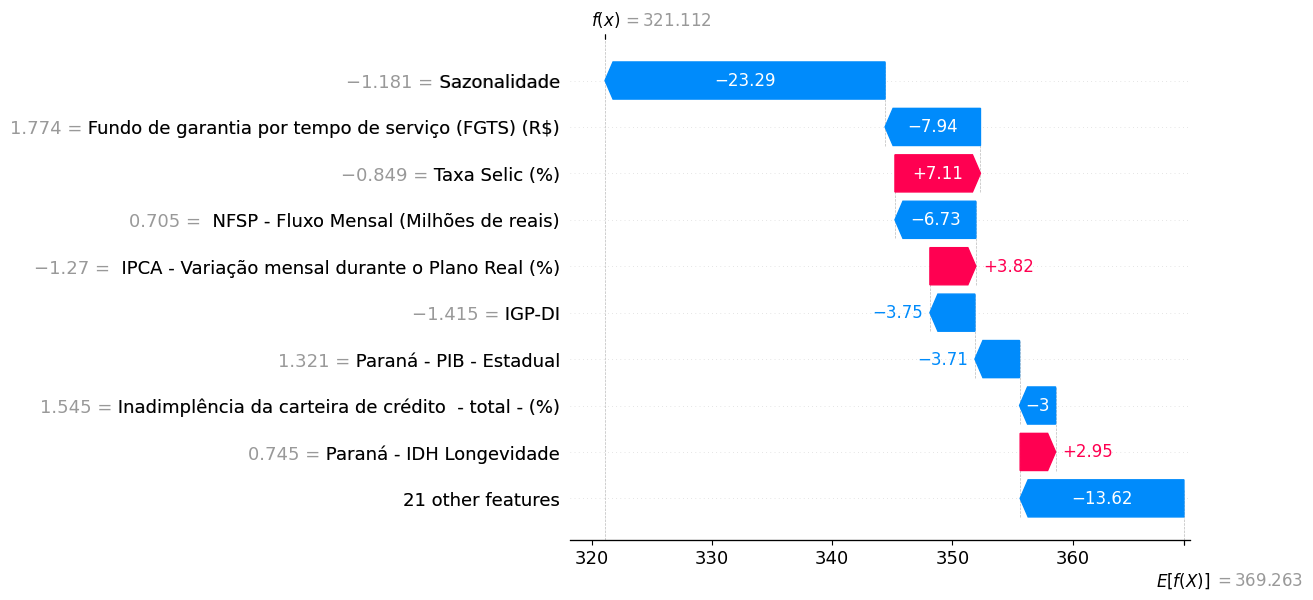

None

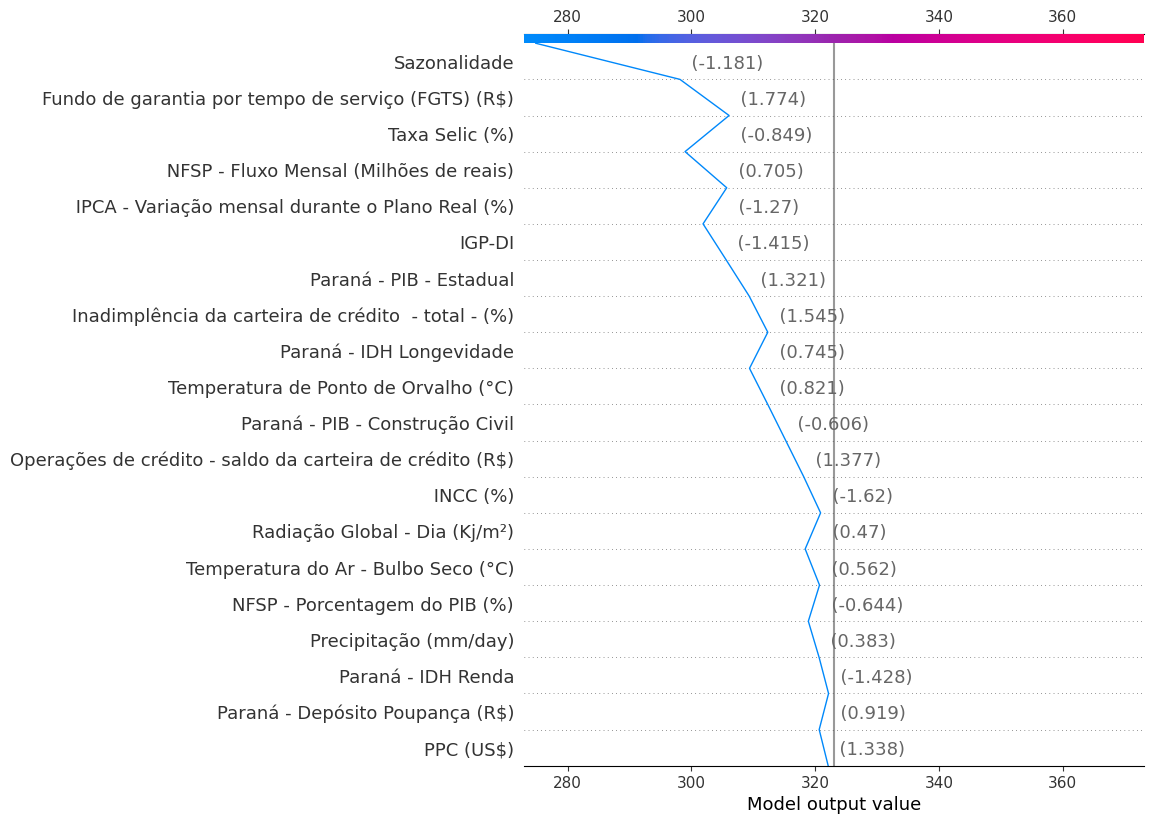

None

['Month-1', 321.1125, 323.005, 1.8925171]

1/1 [==============================] - 0s 32ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

66/66 [==============================] - 0s 538us/step


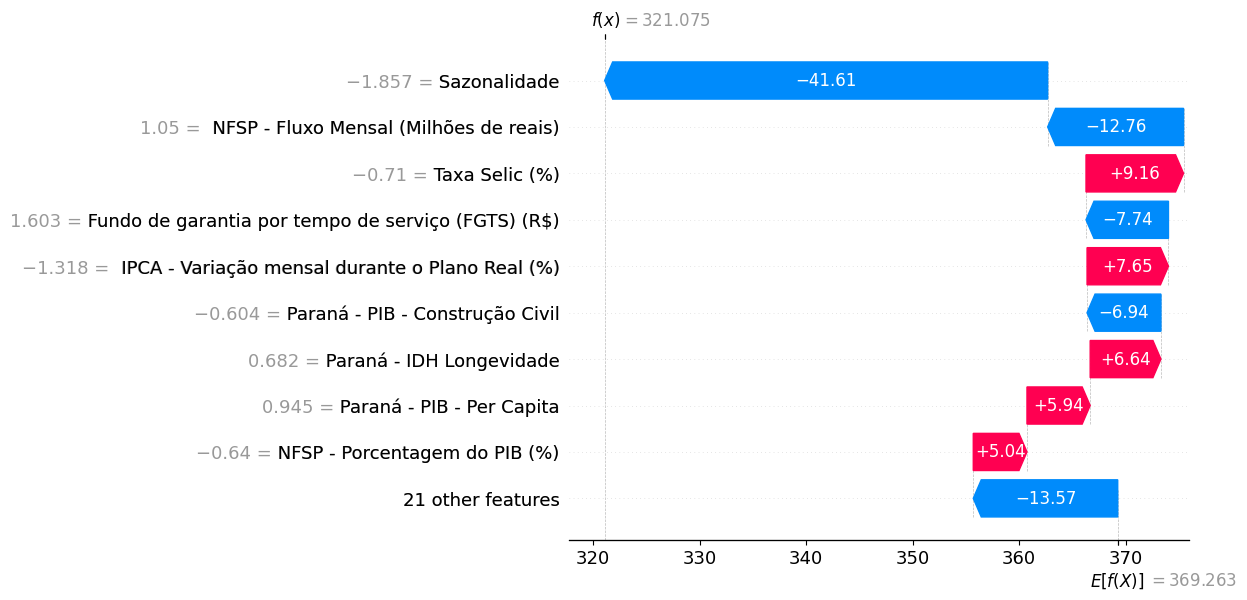

None

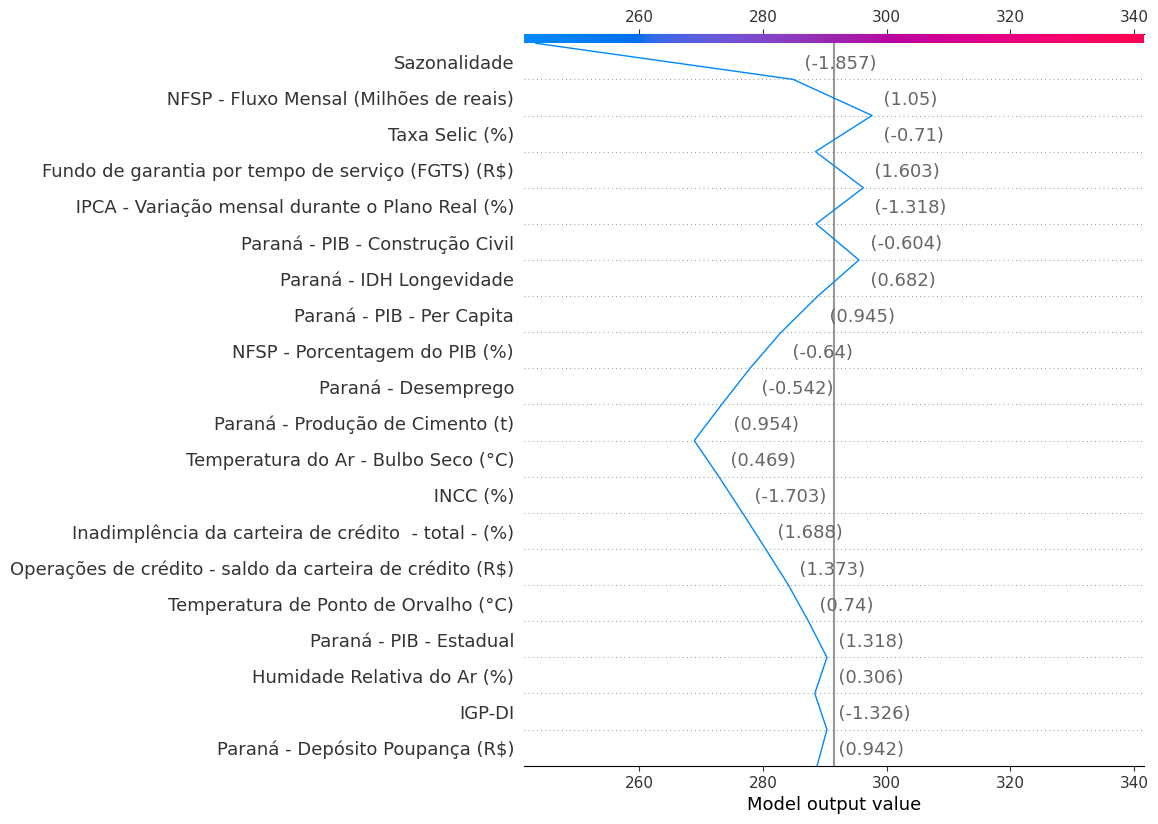

None

['Month-2', 321.07477, 291.453, 29.621765]

1/1 [==============================] - 0s 31ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

66/66 [==============================] - 0s 519us/step


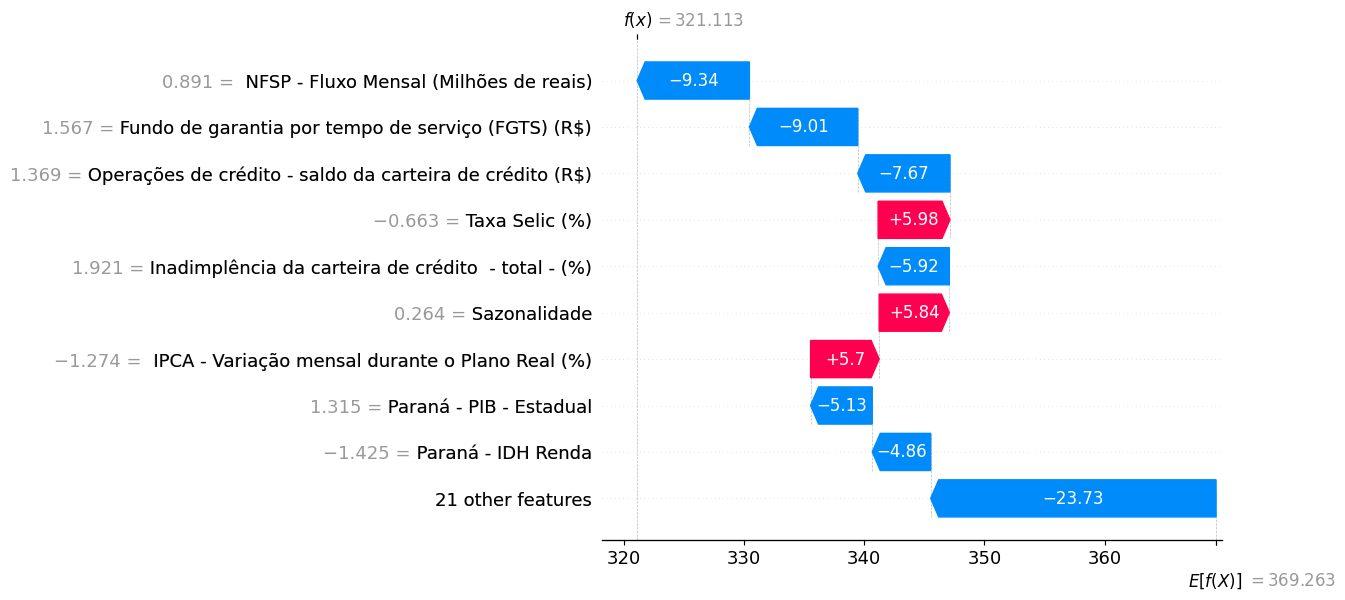

None

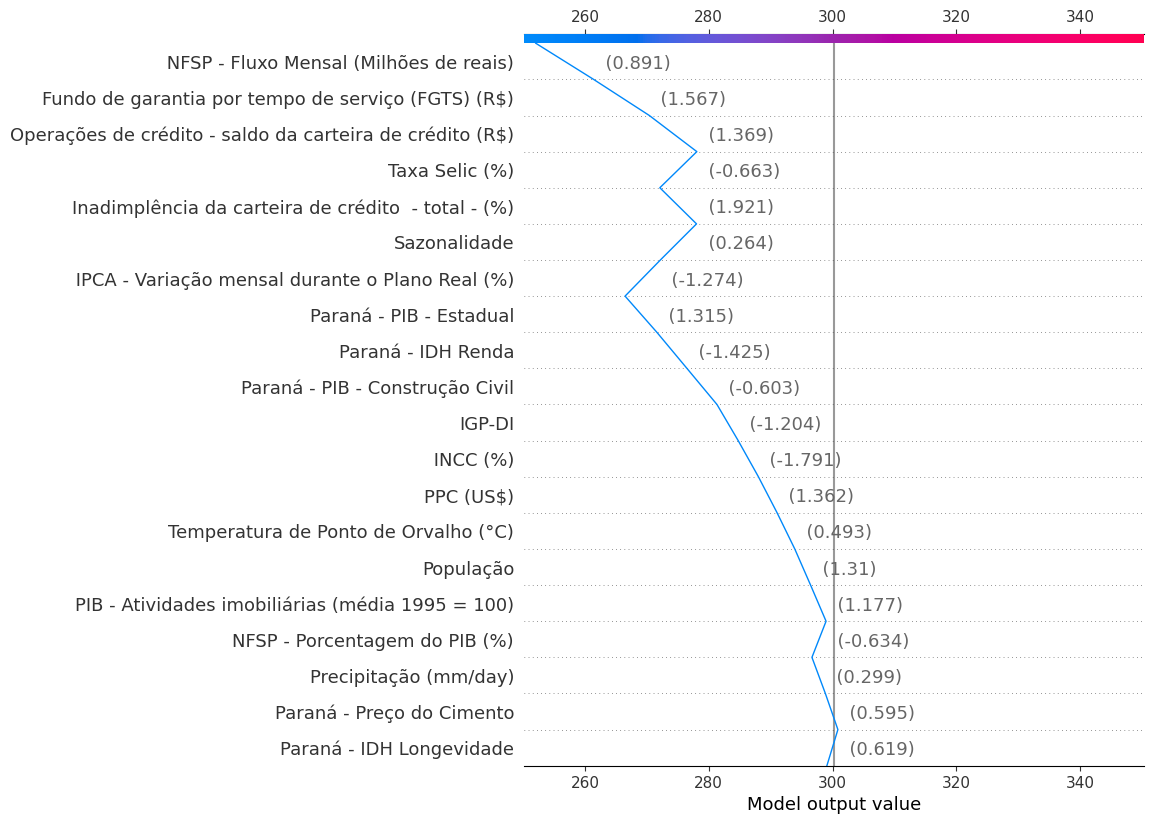

None

['Month-3', 321.11252, 300.203, 20.909515]

1/1 [==============================] - 0s 36ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

66/66 [==============================] - 0s 626us/step


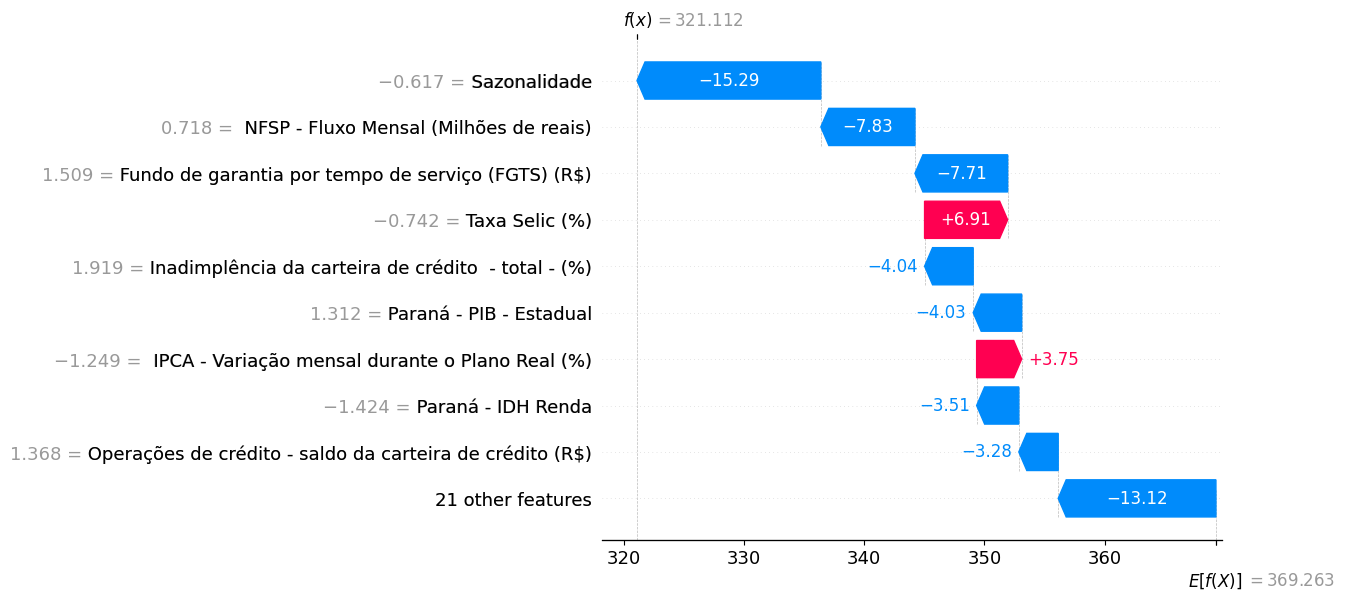

None

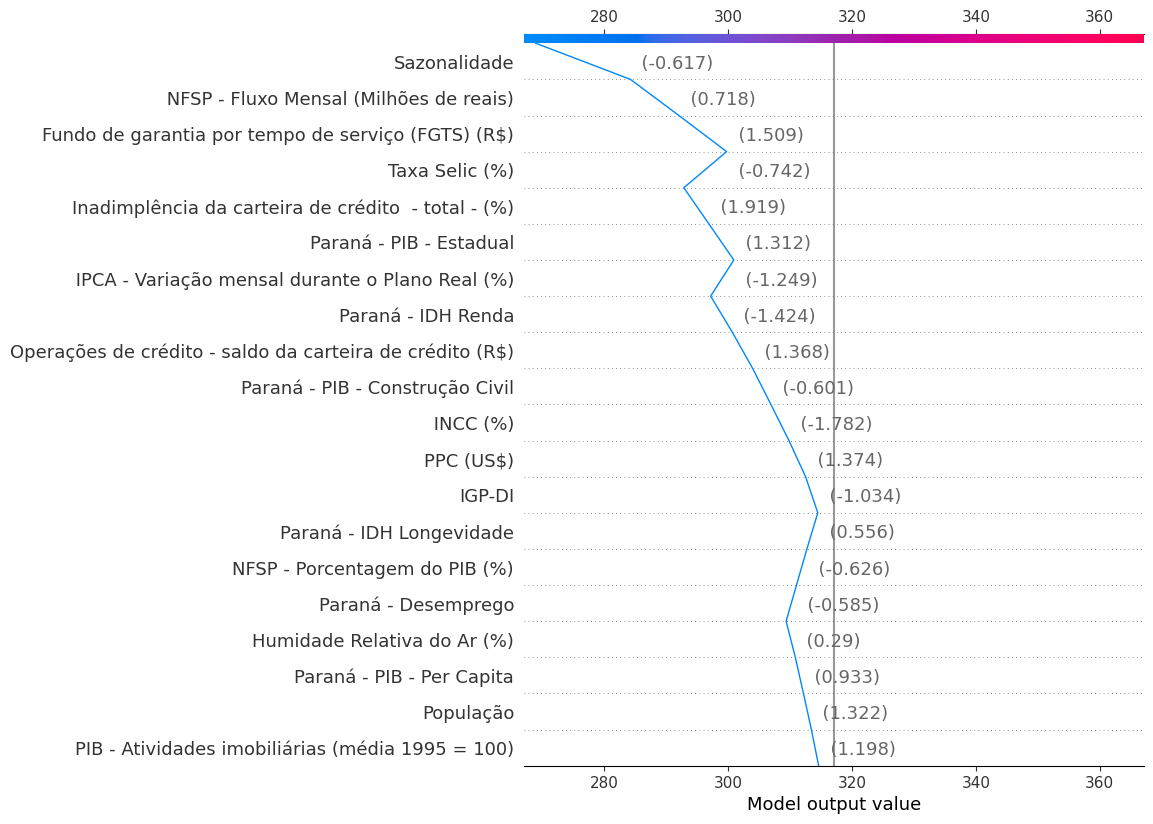

None

['Month-4', 321.11243, 317.058, 4.054413]

1/1 [==============================] - 0s 36ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

66/66 [==============================] - 0s 585us/step


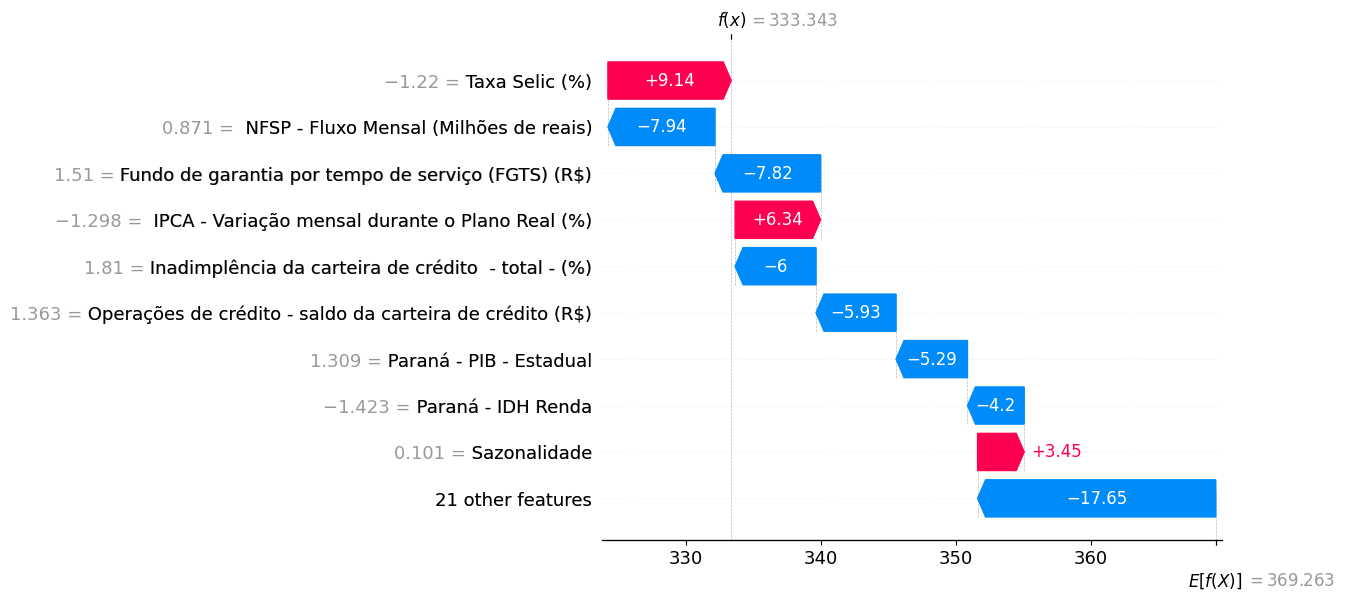

None

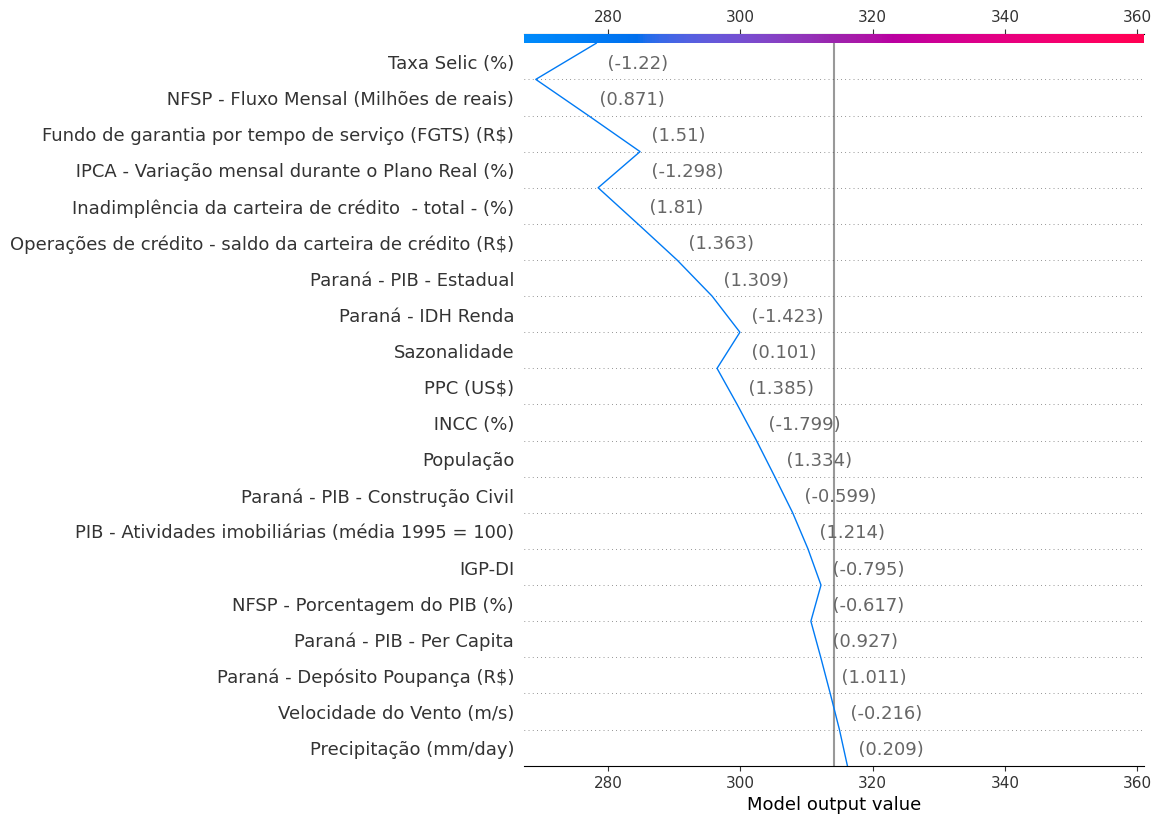

None

['Month-5', 333.34268, 314.142, 19.200684]

1/1 [==============================] - 0s 35ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

66/66 [==============================] - 0s 559us/step


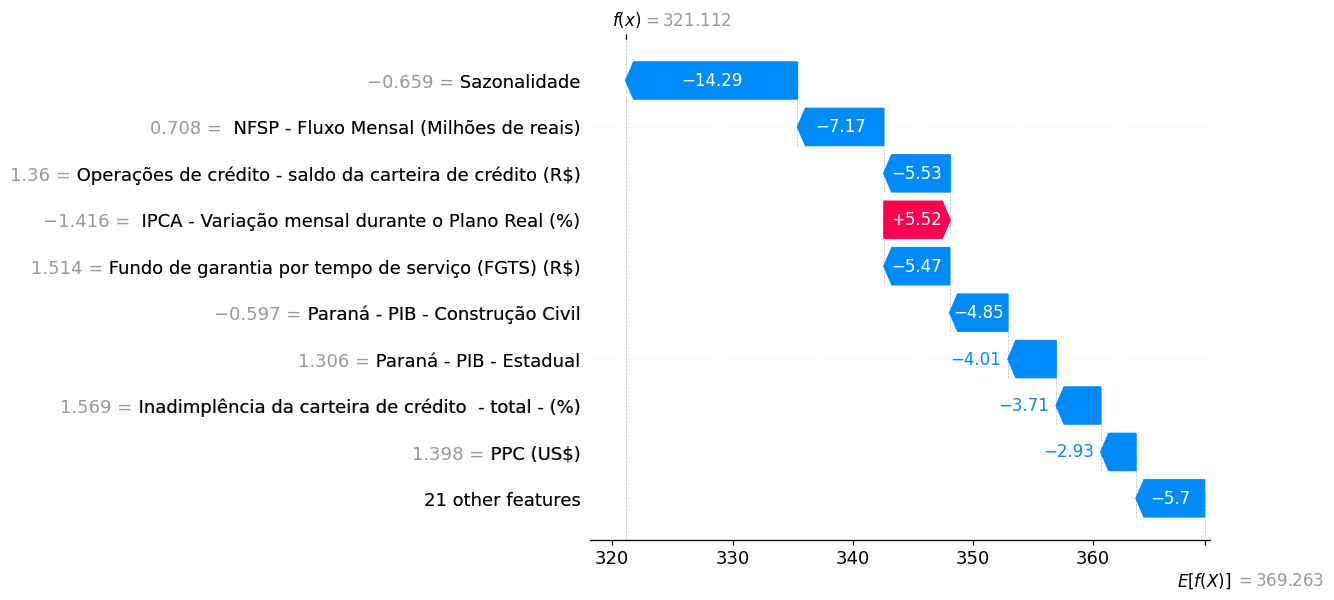

None

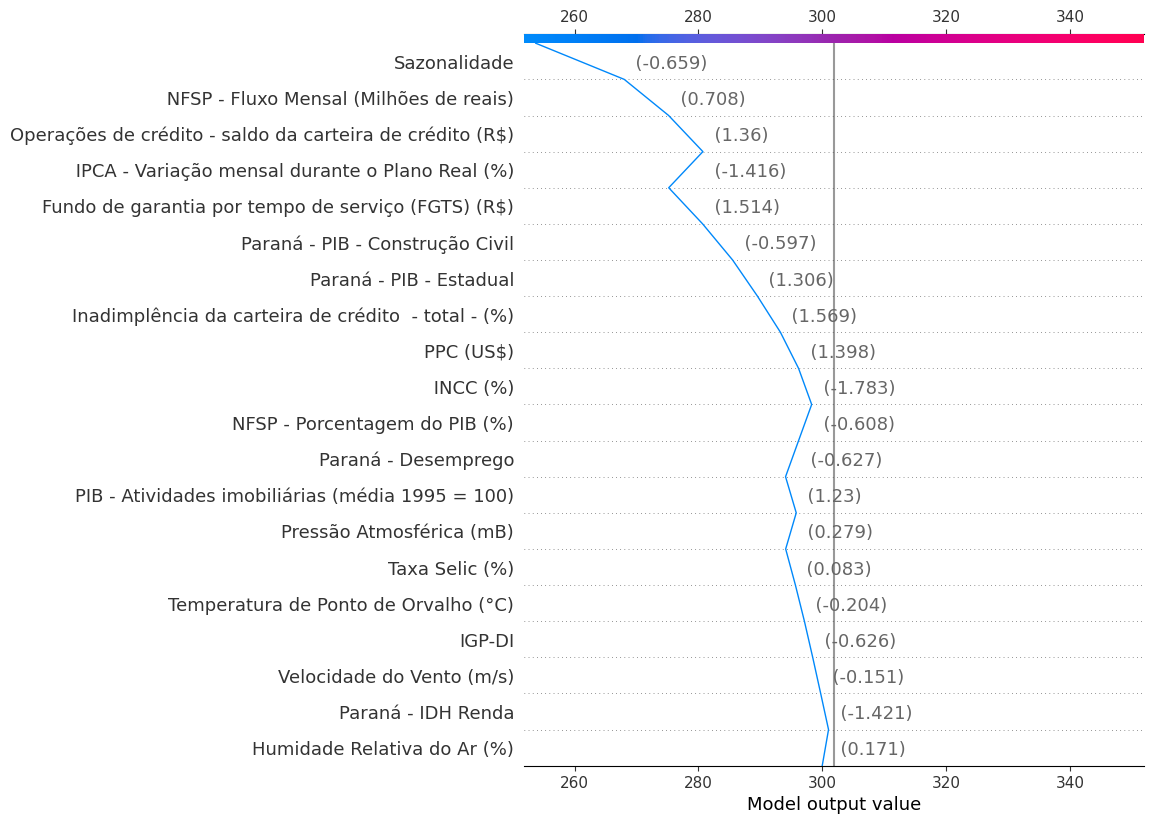

None

['Month-6', 321.1125, 301.878, 19.234497]

1/1 [==============================] - 0s 35ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

66/66 [==============================] - 0s 606us/step


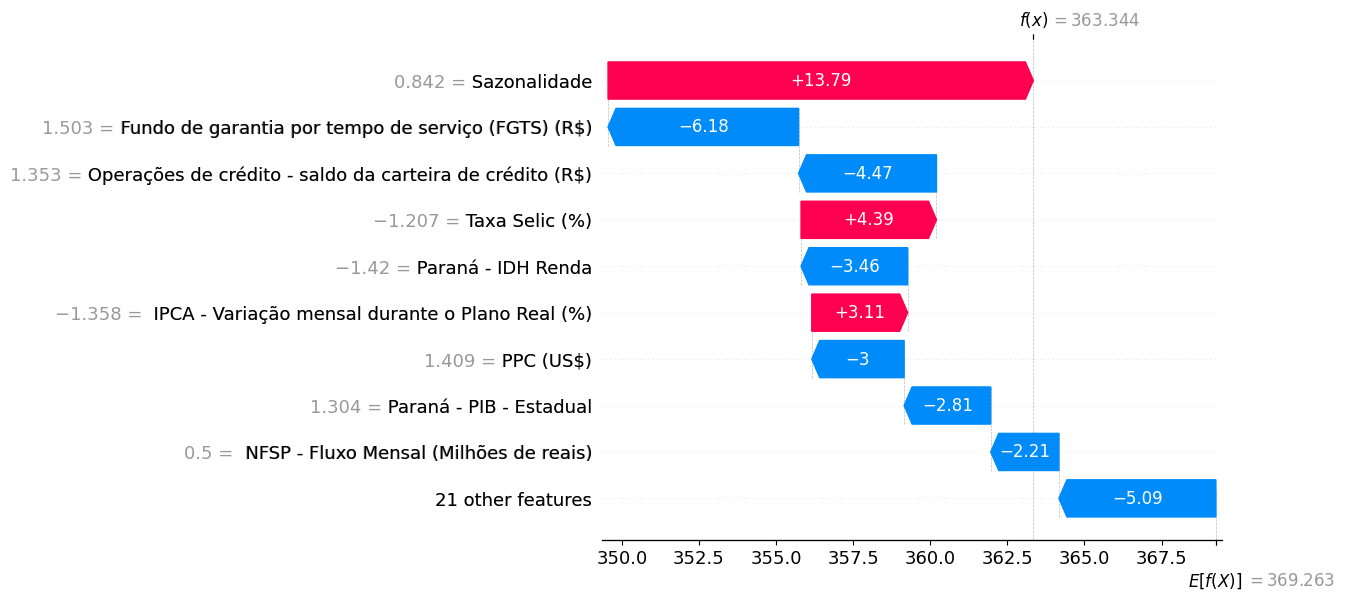

None

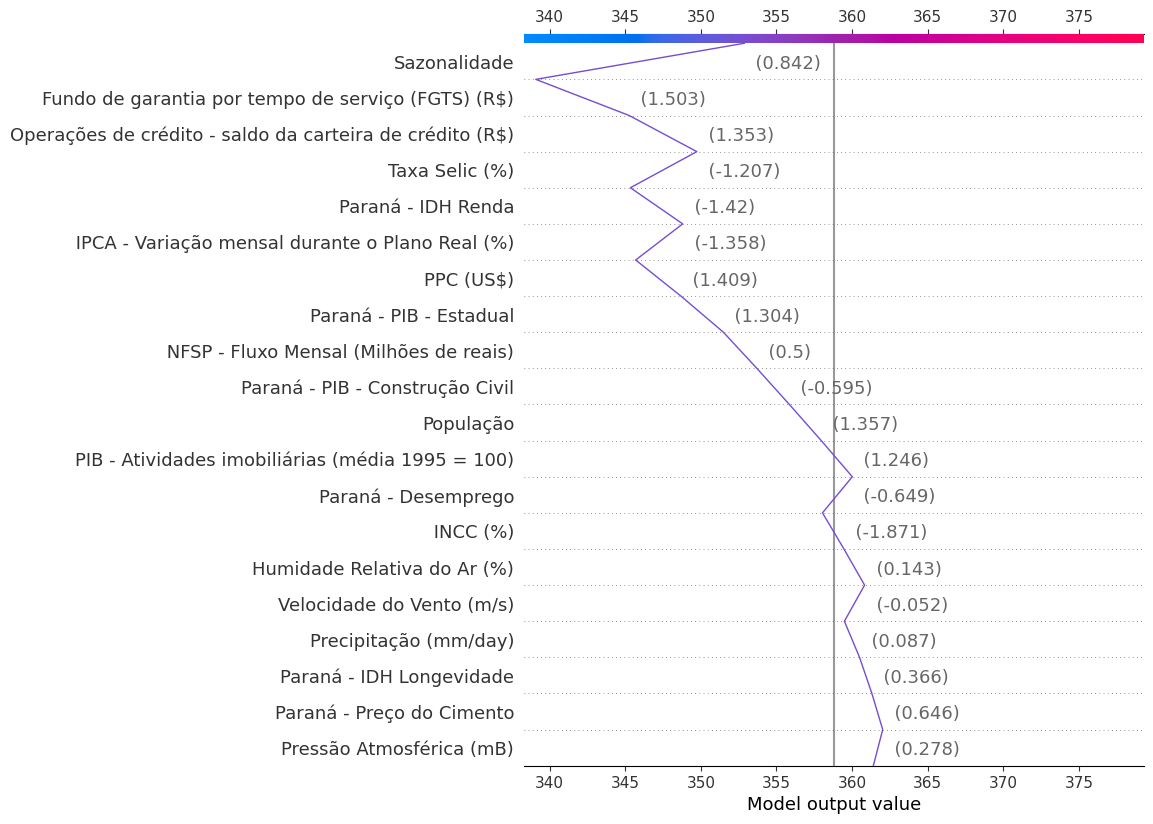

None

['Month-7', 363.3436, 358.797, 4.5466003]

1/1 [==============================] - 0s 47ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

66/66 [==============================] - 0s 623us/step


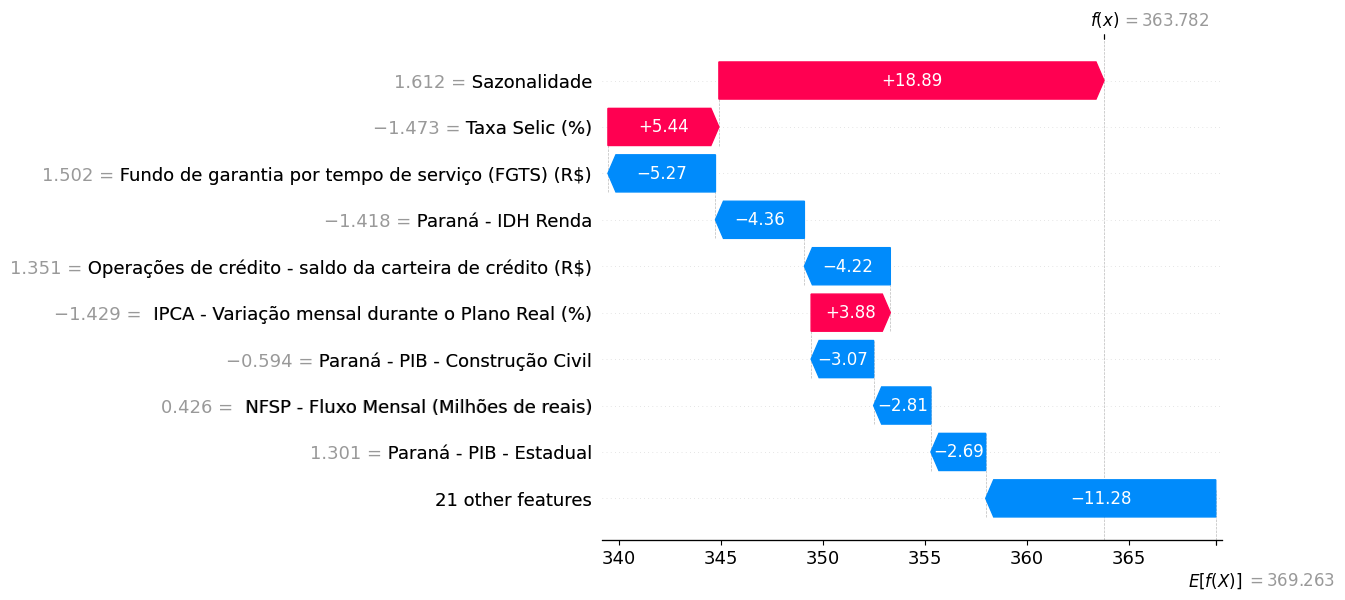

None

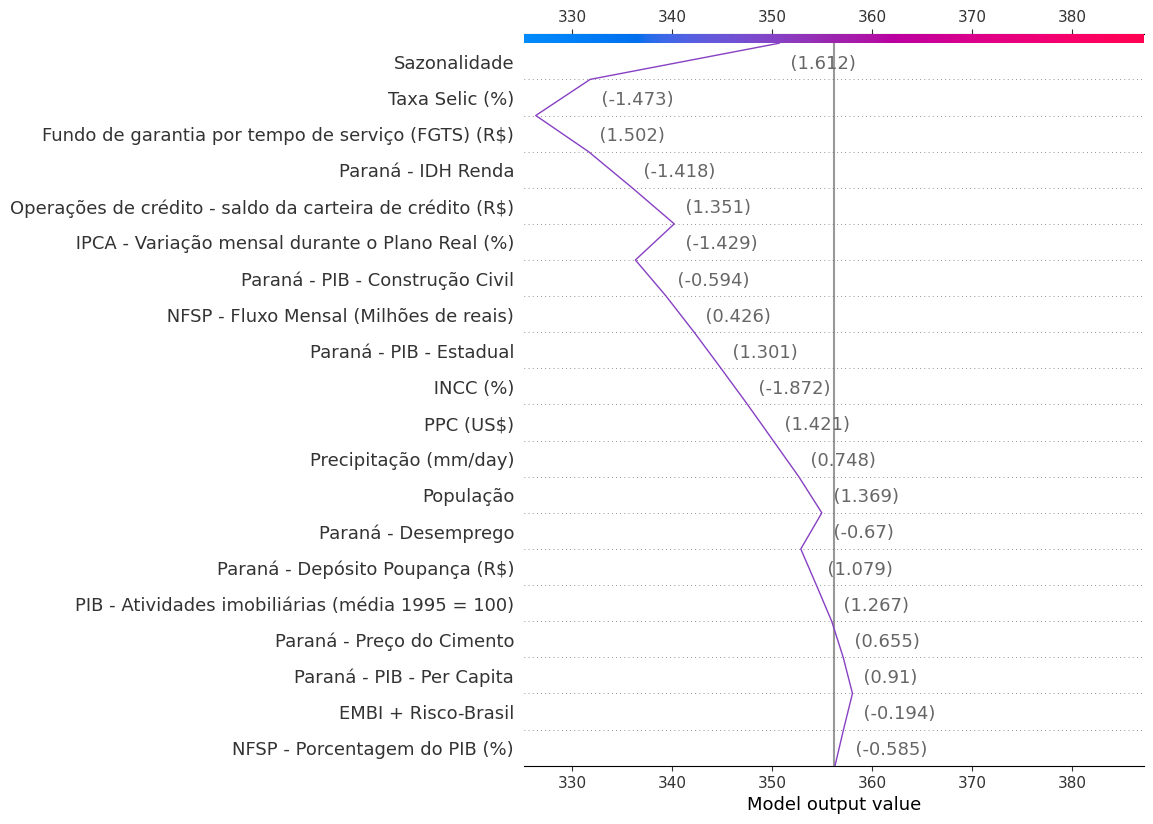

None

['Month-8', 363.78165, 356.169, 7.6126404]

1/1 [==============================] - 0s 34ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

66/66 [==============================] - 0s 603us/step


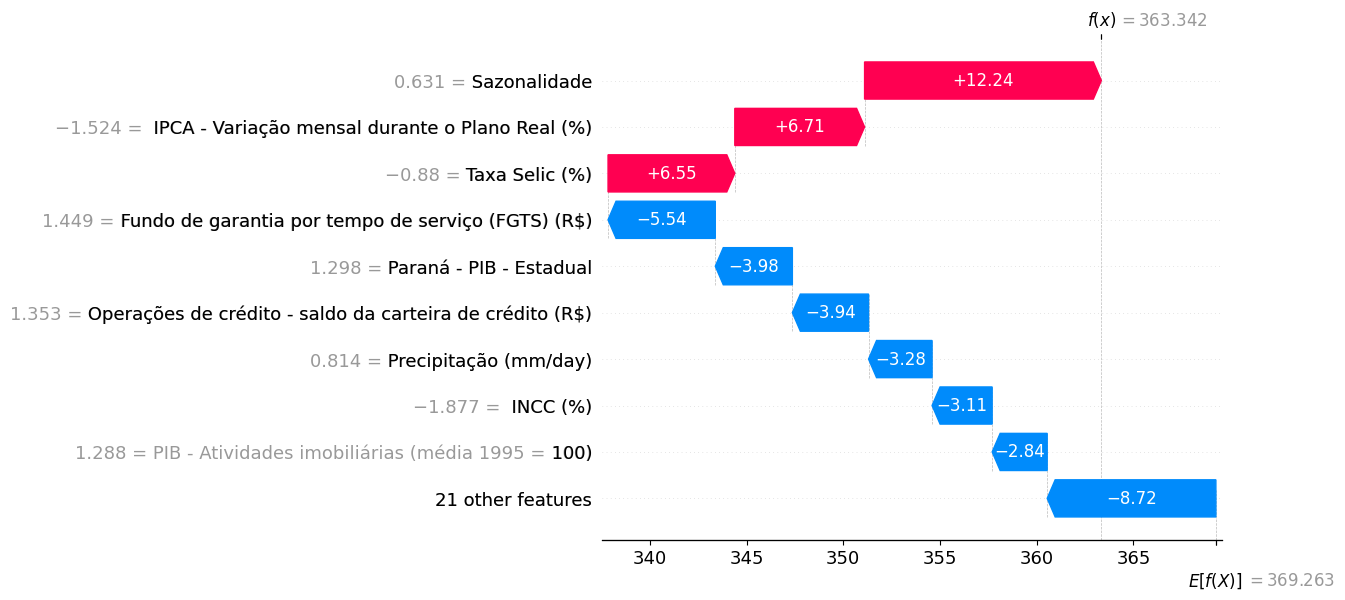

None

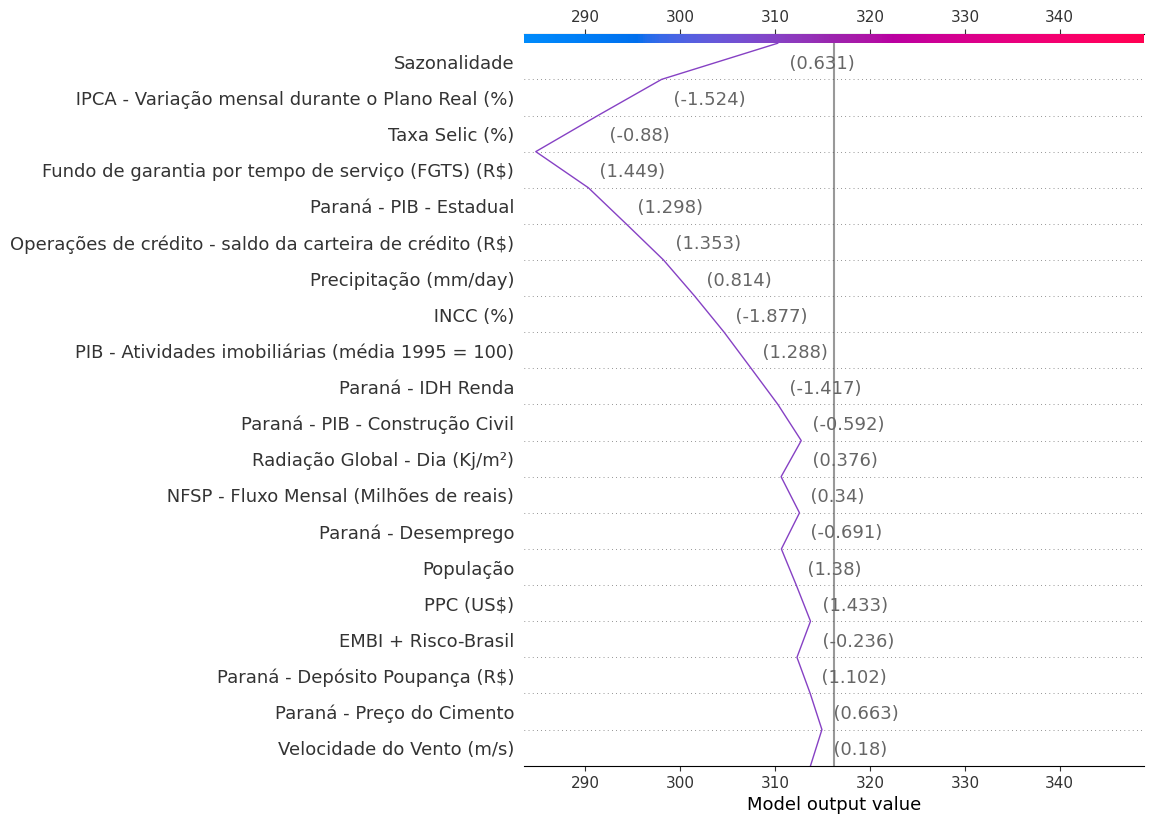

None

['Month-9', 363.34216, 316.188, 47.154175]

1/1 [==============================] - 0s 34ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

66/66 [==============================] - 0s 615us/step


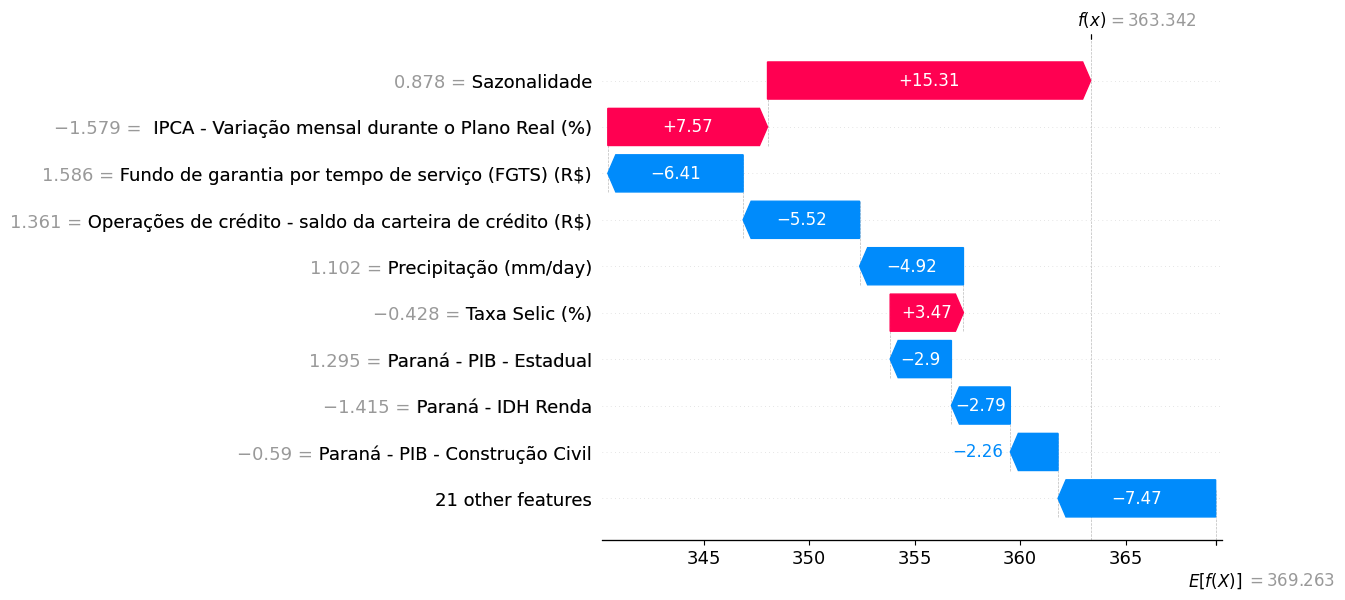

None

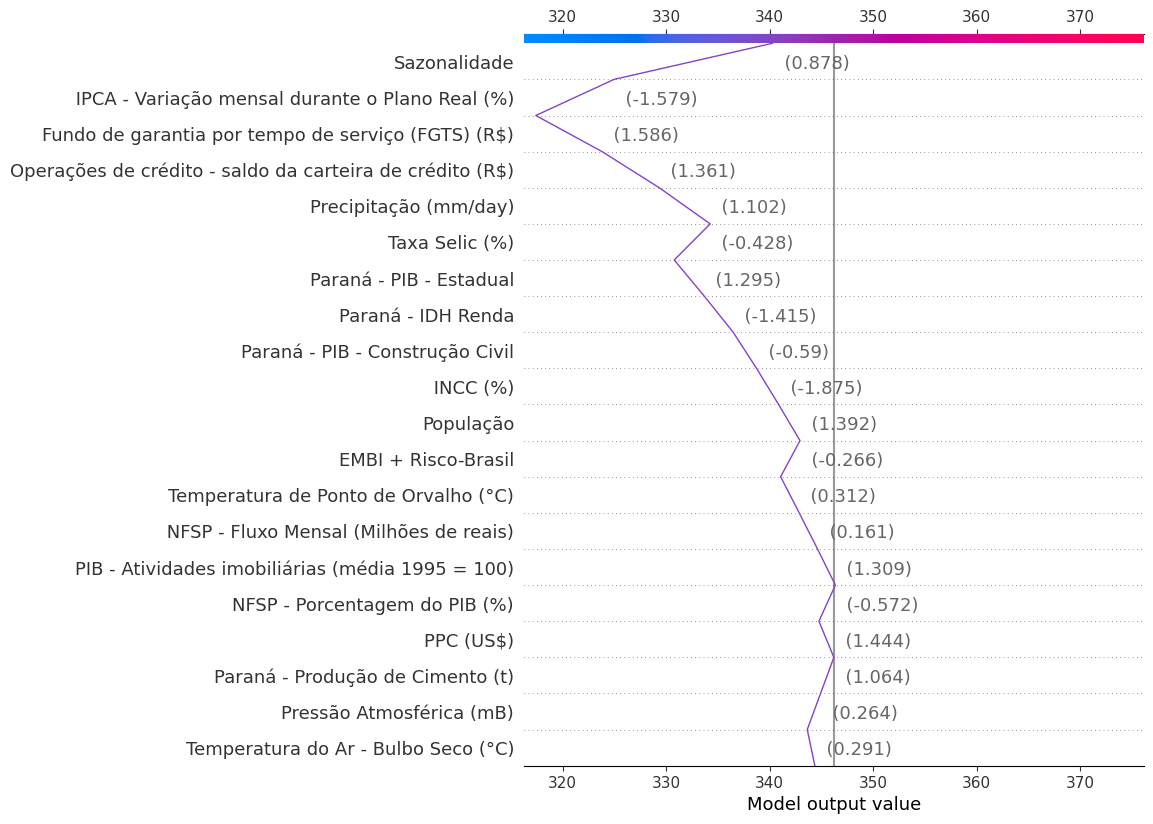

None

['Month-10', 363.34216, 346.214, 17.128174]

1/1 [==============================] - 0s 36ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

66/66 [==============================] - 0s 590us/step


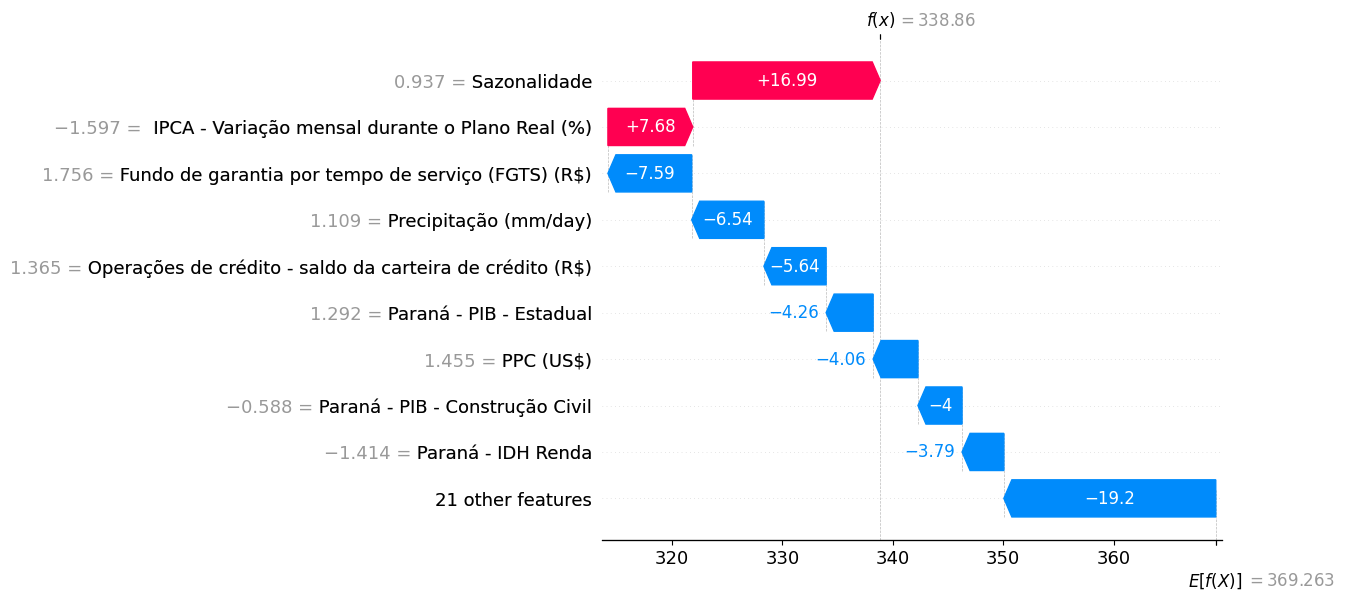

None

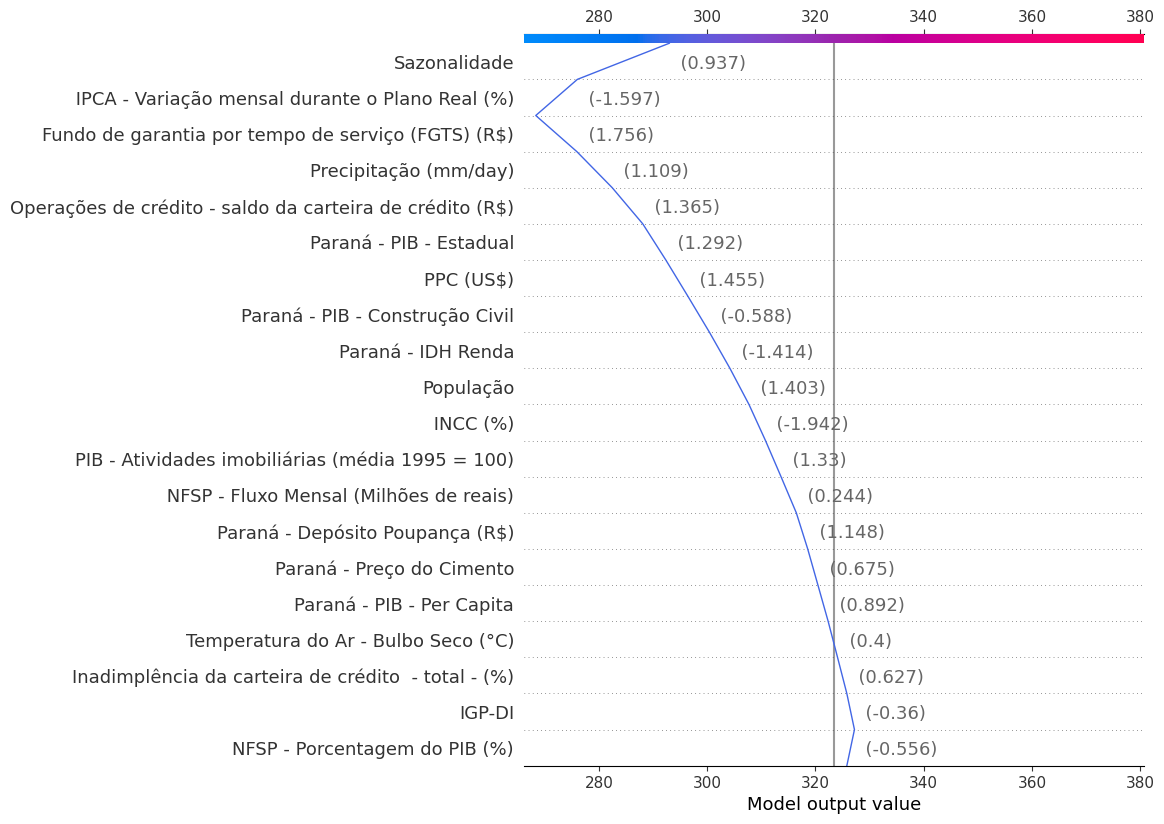

None

['Month-11', 338.85992, 323.401, 15.458923]

1/1 [==============================] - 0s 36ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

66/66 [==============================] - 0s 656us/step


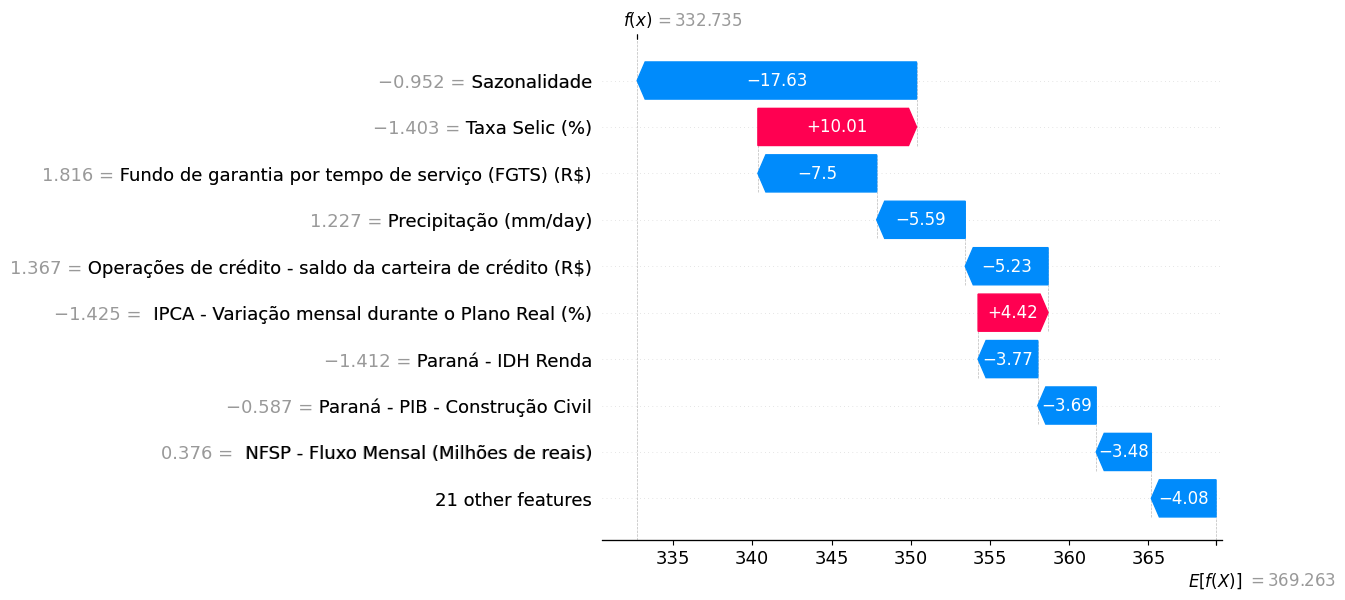

None

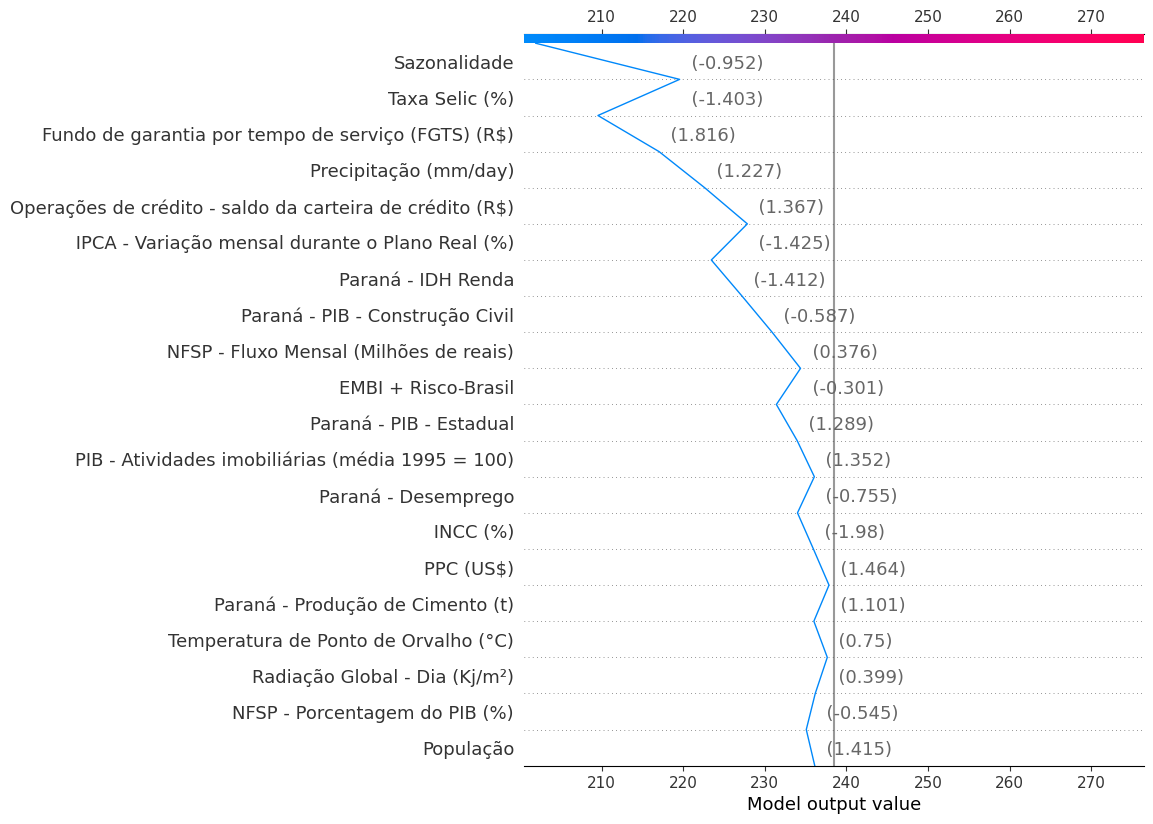

None

['Month-12', 332.73462, 238.466, 94.268616]

0           1           2           3           4   \
Month          Month-1     Month-2     Month-3     Month-4     Month-5   
Prediction  321.112488  321.074768  321.112518  321.112427  333.342682   
Target         323.005     291.453     300.203     317.058     314.142   
Error         1.892517   29.621765   20.909515    4.054413   19.200684   

                    5           6           7           8           9   \
Month          Month-6     Month-7     Month-8     Month-9    Month-10   
Prediction  321.112488  363.343597  363.781647  363.342163  363.342163   
Target         301.878     358.797     356.169     316.188     346.214   
Error        19.234497      4.5466     7.61264   47.154175   17.128174   

                    10          11  
Month         Month-11    Month-12  
Prediction  338.859924  332.734619  
Target         323.401     238.466  
Error        15.458923   94.268616

In [53]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            train_input,
                                            test_input, 
                                            test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

In [54]:
display(mae)
display(mape)

23.423544

0.0825446